In [88]:
#code falls apart halfway through in naming variables and readability good luck

import gspread 
from oauth2client.service_account import ServiceAccountCredentials
import numpy as np
from collections import defaultdict
import statistics
import datetime
from matplotlib import pyplot
import scipy
import itertools

In [89]:
#open google sheets, get info
#if you don't have an account set up with the Google API download the CSV and get the info manually

scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive'] 
creds = ServiceAccountCredentials.from_json_keyfile_name('client_secret.json', scope) 
client = gspread.authorize(creds)
sheet = client.open("imageJ-21776").get_worksheet(0) 

In [90]:
#extract coordinate values and convert from string to array

x1_val_list = [int(x1_val) for x1_val in sheet.col_values(4)[1:]] 
x1_val_list = np.array(x1_val_list)

y1_val_list = [int(y1_val) for y1_val in sheet.col_values(5)[1:]]
y1_val_list = np.array(y1_val_list)

x2_val_list = [int(x2_val) for x2_val in sheet.col_values(6)[1:]]
x2_val_list = np.array(x2_val_list)

y2_val_list = [int(y2_val) for y2_val in sheet.col_values(7)[1:]]
y2_val_list = np.array(y2_val_list)


x1_scale_list = [int(x1_val) for x1_val in sheet.col_values(8)[1:]]
x1_scale_list = np.array(x1_scale_list)

y1_scale_list = [int(y1_val) for y1_val in sheet.col_values(9)[1:]]
y1_scale_list = np.array(y1_scale_list)

x2_scale_list = [int(x2_val) for x2_val in sheet.col_values(10)[1:]]
x2_scale_list = np.array(x2_scale_list)

y2_scale_list = [int(y2_val) for y2_val in sheet.col_values(11)[1:]]
y2_scale_list = np.array(y2_scale_list)

In [91]:
#calculate distances

tegula_pixel_distance = ( (x2_val_list - x1_val_list)**2 + (y2_val_list - y1_val_list)**2 )**0.5 #distance formula

scale_pixel_distance = ( (x2_scale_list - x1_scale_list)**2 + (y2_scale_list - y1_scale_list)**2 )**0.5

pixel_to_cm_conversion = 0.5 / scale_pixel_distance

tegula_distance_cm_array = tegula_pixel_distance * pixel_to_cm_conversion

In [92]:
#group data together by ID
#one group (distance_grouped_by_id_yes_and_no) had both yes and no for answer in 'Were you able to measure the bee?' column
#one group (distance_grouped_by_id_yes) had only yes for answer in 'Were you able to measure the bee?' column

subject_id_list = sheet.col_values(13)[1:]
confidence_list = sheet.col_values(12)[1:] #whether or not they were able to measure the bee
user_list = sheet.col_values(3)[1:]

distance_grouped_by_id_yes_and_no = defaultdict(list) #group by ID, includes confidence yes and no
distance_grouped_by_id_yes = defaultdict(list) #group by ID, includes only confidence yes

for subject_id, tegula_distance_cm, answer, user in zip(subject_id_list, tegula_distance_cm_array, confidence_list, user_list):
    if user != 'VeronicaGutierrez':
        distance_grouped_by_id_yes_and_no[ subject_id ].append(tegula_distance_cm)
        if answer == 'Yes':
            distance_grouped_by_id_yes[ subject_id ].append(tegula_distance_cm)

In [93]:
standard_deviation_yes_and_no = []
standard_deviation_yes = []

average_yes_and_no = []
average_yes = []

for key,value in distance_grouped_by_id_yes_and_no.items():
    standard_deviation_yes_and_no.append( statistics.pstdev(value) )
    average_yes_and_no.append( statistics.mean(value) )

for key,value in distance_grouped_by_id_yes.items():
    standard_deviation_yes.append( statistics.pstdev(value) )
    average_yes.append( statistics.mean(value) )

standard_deviation_yes_and_no_average = statistics.mean(standard_deviation_yes_and_no)
standard_deviation_yes_average = statistics.mean(standard_deviation_yes)

average_yes_and_no_average = statistics.mean(average_yes_and_no)
average_yes_average = statistics.mean(average_yes)

In [94]:
percent_difference_standard_deviation = 100 * abs( standard_deviation_yes_and_no_average - standard_deviation_yes_average) / ( (standard_deviation_yes_and_no_average + standard_deviation_yes_average) / 2 )
percent_difference_average = 100 * abs( average_yes_and_no_average - average_yes_average) / ( (average_yes_and_no_average + average_yes_average) / 2 )

The standard deviation between Tegula Measurements for a given subject, averaged for all subjects is 0.04722848666931982
The standard deviation between Tegula Measurements for a given subject, averaged for all subjects, excluding measurements with "No" answers in the question "Were you able to measure the bee?", is 0.04472580920295646

The percent difference between these standard deviations is 5.44%


The average Tegula Measurements for a given subject, averaged for all subjects is 0.22072870001285533
The average Tegula Measurements for a given subject, averaged for all subjects, but excluding excluding measurements with "No" answers in the question "Were you able to measure the bee?", is 0.220581770489212

The percent difference between these averages is 0.07%


Text(0, 0.5, 'Average Standard Deviation')

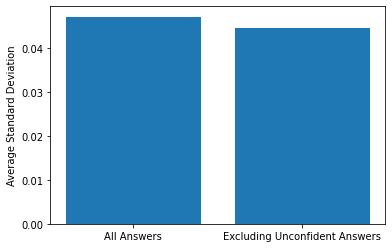

In [95]:
print(f'The standard deviation between Tegula Measurements for a given subject, averaged for all subjects is {standard_deviation_yes_and_no_average}')
print(f'The standard deviation between Tegula Measurements for a given subject, averaged for all subjects, excluding measurements with "No" answers in the question "Were you able to measure the bee?", is {standard_deviation_yes_average}')
print()
print(f'The percent difference between these standard deviations is {round(percent_difference_standard_deviation, 2)}%')
print()
print()
print(f'The average Tegula Measurements for a given subject, averaged for all subjects is {average_yes_and_no_average}')
print(f'The average Tegula Measurements for a given subject, averaged for all subjects, but excluding excluding measurements with "No" answers in the question "Were you able to measure the bee?", is {average_yes_average}')
print()
print(f'The percent difference between these averages is {round(percent_difference_average, 2)}%')

pyplot.bar(['All Answers', 'Excluding Unconfident Answers'], [standard_deviation_yes_and_no_average,standard_deviation_yes_average])
pyplot.ylabel('Average Standard Deviation')

In [96]:
distance_grouped_by_id_find_yes = defaultdict(list)

for subject_id, tegula_distance_cm, answer, user in zip(subject_id_list, tegula_distance_cm_array, confidence_list, user_list):
    if user != 'VeronicaGutierrez':
        distance_grouped_by_id_find_yes[ subject_id ].append(tegula_distance_cm)
        distance_grouped_by_id_find_yes[ subject_id ].append(answer)


distance_grouped_by_id_exclude_all_yes = defaultdict(list)

for key, value in distance_grouped_by_id_find_yes.items():
    if 'No' in value:
        distance_grouped_by_id_exclude_all_yes[key] = value


distance_grouped_by_id_exclude_all_yes_reformat_yes_and_no = defaultdict(list)

for key, value in distance_grouped_by_id_exclude_all_yes.items():
    new_value = []
    for item in value:
        if type(item) == np.float64:
            new_value.append(item)
    distance_grouped_by_id_exclude_all_yes_reformat_yes_and_no[key] = new_value

In [97]:
distance_grouped_by_id_exclude_all_yes_reformat_yes = defaultdict(list)

for key,value in distance_grouped_by_id_exclude_all_yes_reformat_yes_and_no.items(): #67 keys with no, remove data specific to No
    for item in value:
        for subject_id, tegula_distance, answer in zip(subject_id_list, tegula_distance_cm_array, confidence_list):
            if subject_id == key and tegula_distance == item and answer == 'Yes':
                distance_grouped_by_id_exclude_all_yes_reformat_yes[key].append(tegula_distance)

In [98]:
standard_deviation_exclude_all_yes_yes = []
standard_deviation_exclude_all_yes_yes_and_no = []

average_exclude_all_yes_yes = []
average_exclude_all_yes_yes_and_no = []

for key,value in distance_grouped_by_id_exclude_all_yes_reformat_yes.items():
    standard_deviation_exclude_all_yes_yes.append( statistics.pstdev(value) )
    average_exclude_all_yes_yes.append( statistics.mean(value) )

for key,value in distance_grouped_by_id_exclude_all_yes_reformat_yes_and_no.items():
    standard_deviation_exclude_all_yes_yes_and_no.append( statistics.pstdev(value) )
    average_exclude_all_yes_yes_and_no.append( statistics.mean(value) )

standard_deviation_exclude_all_yes_yes_average = statistics.mean(standard_deviation_exclude_all_yes_yes)
standard_deviation_exclude_all_yes_yes_and_no_average = statistics.mean(standard_deviation_exclude_all_yes_yes_and_no)

average_exclude_all_yes_yes_average = statistics.mean(average_exclude_all_yes_yes)
average_exclude_all_yes_yes_and_no_average = statistics.mean(average_exclude_all_yes_yes_and_no)

In [99]:
percent_difference_standard_deviation2 = 100 * abs( standard_deviation_exclude_all_yes_yes_average - standard_deviation_exclude_all_yes_yes_and_no_average) / ( (standard_deviation_exclude_all_yes_yes_average + standard_deviation_exclude_all_yes_yes_and_no_average) / 2 )
percent_difference_average2 = 100 * abs( average_exclude_all_yes_yes_average - average_exclude_all_yes_yes_and_no_average) / ( (average_exclude_all_yes_yes_average + average_exclude_all_yes_yes_and_no_average) / 2 )

The standard deviation between Tegula Measurements for a given subject, averaged only for subjects which had at least one "No" answer in the question "Were you able to measure the bee?", is 0.050155275464918145
The standard deviation between Tegula Measurements for a given subject, averaged only for subjects which had at least one "No" answer in the question "Were you able to measure the bee?", but excluding the data for this "No" answer, is 0.03572738950845824

The percent difference between these standard deviations is 33.599%


The average Tegula Measurement for a given subject, averaged only for subjects which had at least one "No" answer in the question "Were you able to measure the bee?", is 0.20990596673975556
The average Tegula Measurement for a given subject, averaged only for subjects which had at least one "No" answer in the question "Were you able to measure the bee?", is but exluding the data for this "No" answer, is 0.20827931750233009

The percent difference between thes

Text(0, 0.5, 'Average Standard Deviation')

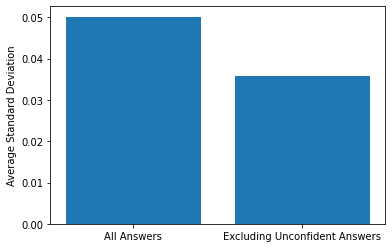

In [100]:
print(f'The standard deviation between Tegula Measurements for a given subject, averaged only for subjects which had at least one "No" answer in the question "Were you able to measure the bee?", is {standard_deviation_exclude_all_yes_yes_and_no_average}')
print(f'The standard deviation between Tegula Measurements for a given subject, averaged only for subjects which had at least one "No" answer in the question "Were you able to measure the bee?", but excluding the data for this "No" answer, is {standard_deviation_exclude_all_yes_yes_average}')
print()
print(f'The percent difference between these standard deviations is {round(percent_difference_standard_deviation2, 3)}%')
print()
print()
print(f'The average Tegula Measurement for a given subject, averaged only for subjects which had at least one "No" answer in the question "Were you able to measure the bee?", is {average_exclude_all_yes_yes_and_no_average}')
print(f'The average Tegula Measurement for a given subject, averaged only for subjects which had at least one "No" answer in the question "Were you able to measure the bee?", is but exluding the data for this "No" answer, is {average_exclude_all_yes_yes_average}')
print()
print(f'The percent difference between these averages is {round(percent_difference_average2, 2)}%')

pyplot.bar(['All Answers', 'Excluding Unconfident Answers'], [standard_deviation_exclude_all_yes_yes_and_no_average,standard_deviation_exclude_all_yes_yes_average])
pyplot.ylabel('Average Standard Deviation')

In [101]:
distance_grouped_by_id_exclude_no = defaultdict(list)

for key, value in distance_grouped_by_id_find_yes.items():
    if 'No' not in value:
        distance_grouped_by_id_exclude_no[key] = value


distance_grouped_by_id_exclude_no_reformat = defaultdict(list)

for key, value in distance_grouped_by_id_exclude_no.items():
    new_value = []
    for item in value:
        if type(item) == np.float64:
            new_value.append(item)
    distance_grouped_by_id_exclude_no_reformat[key] = new_value

In [102]:
standard_deviation_exclude_no = []

average_exclude_no = []

for key,value in distance_grouped_by_id_exclude_no_reformat.items():
    standard_deviation_exclude_no.append( statistics.pstdev(value) )
    average_exclude_no.append( statistics.mean(value) )

standard_deviation_exclude_no_average = statistics.mean(standard_deviation_exclude_no)

average_exclude_no_average = statistics.mean(average_exclude_no)

In [103]:
percent_difference_standard_deviation3 = 100 * abs( standard_deviation_exclude_no_average - standard_deviation_exclude_all_yes_yes_and_no_average) / ( (standard_deviation_exclude_no_average + standard_deviation_exclude_all_yes_yes_and_no_average) / 2 )
percent_difference_average3 = 100 * abs( average_exclude_no_average - average_exclude_all_yes_yes_and_no_average) / ( (average_exclude_no_average + average_exclude_all_yes_yes_and_no_average) / 2 )

In [104]:
print(f'The standard deviation between Tegula Measurements for a given subject, averaged only for subjects which did not have a "No" answer in the question "Were you able to measure the bee?", is {standard_deviation_exclude_no_average}')
print(f'The standard deviation between Tegula Measurements for a given subject, averaged only for subjects which had at least one "No" answer in the question "Were you able to measure the bee?", is {standard_deviation_exclude_all_yes_yes_and_no_average}')
print()
print(f'The percent difference between these standard deviations is {round(percent_difference_standard_deviation3, 2)}%')
print()
print()
print('The following data is meaningless, as it involves comparing average Tegula sizes between different subjects.')
print()
print(f'The averages Tegula Measurements for a given subject, averaged only for subjects which did not have a "No" answer in the question "Were you able to measure the bee?", is {average_exclude_no_average}')
print(f'The average Tegula Measurements for a given subject, averaged only for subjects which had at least one "No" answer in the question "Were you able to measure the bee?", is {average_exclude_all_yes_yes_and_no_average}')
print()
print(f'The percent difference between these averages is {round(percent_difference_average3, 2)}%')

The standard deviation between Tegula Measurements for a given subject, averaged only for subjects which did not have a "No" answer in the question "Were you able to measure the bee?", is 0.0467525282972201
The standard deviation between Tegula Measurements for a given subject, averaged only for subjects which had at least one "No" answer in the question "Were you able to measure the bee?", is 0.050155275464918145

The percent difference between these standard deviations is 7.02%


The following data is meaningless, as it involves comparing average Tegula sizes between different subjects.

The averages Tegula Measurements for a given subject, averaged only for subjects which did not have a "No" answer in the question "Were you able to measure the bee?", is 0.22248870760823805
The average Tegula Measurements for a given subject, averaged only for subjects which had at least one "No" answer in the question "Were you able to measure the bee?", is 0.20990596673975556

The percent differenc

In [105]:
time_started = sheet.col_values(14)[1:]
time_finished = sheet.col_values(15)[1:]

Excludes quickest 5% and slowest 5% of data, starting at 9 seconds and ending at 467 seconds.
Average Time to Complete: 58
Median Time to Complete: 33.0


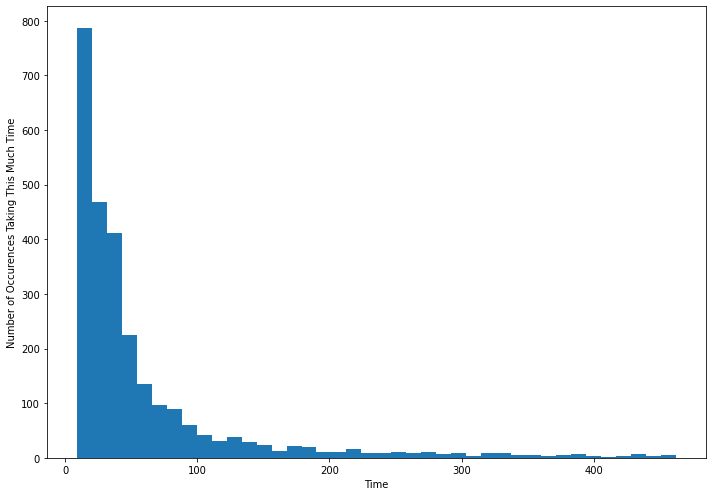

In [106]:
time_list = []
for start_time,finish_time in zip(time_started, time_finished):
    finish = datetime.datetime.strptime(finish_time, "%d-%b-%Y %H:%M:%S")
    start = datetime.datetime.strptime(start_time, "%d-%b-%Y %H:%M:%S")
    time_took = finish - start
    time_list.append(time_took.seconds)

time_list = np.array(time_list)
time_list.sort()
time_list_short = time_list[ int( len(time_list)*0.05 ) : int( len(time_list)*0.95 ) ]

print(f'Excludes quickest 5% and slowest 5% of data, starting at {time_list[ int( len(time_list)*0.05 )]} seconds and ending at {time_list[ int( len(time_list)*0.95 ) ]} seconds.')

print(f'Average Time to Complete: {statistics.mean(time_list_short)}')
print(f'Median Time to Complete: {statistics.median(time_list_short)}')

fig, axs = pyplot.subplots(1, 1,
                        figsize =(10, 7),
                        tight_layout = True)
 
axs.hist(time_list_short, bins = 40 )
axs.set_xlabel('Time')
axs.set_ylabel('Number of Occurences Taking This Much Time')
pyplot.show()

In [107]:
time_list = []
for start_time,finish_time in zip(time_started, time_finished):
    finish = datetime.datetime.strptime(finish_time, "%d-%b-%Y %H:%M:%S")
    start = datetime.datetime.strptime(start_time, "%d-%b-%Y %H:%M:%S")
    time_took = finish - start
    time_list.append(time_took.seconds)

time_accuracy = defaultdict(list)

for subject_id, tegula_distance_cm, time, user in zip(subject_id_list, tegula_distance_cm_array, time_list, user_list):
    if user != 'VeronicaGutierrez':
        time_accuracy[ subject_id ].append(tegula_distance_cm)
        time_accuracy[ subject_id ].append(time)

In [108]:
time_vs_dissimilarity = []

for key,value in time_accuracy.items():
    for distance_iter in range(0, len(value), 2):
        distance = value[distance_iter]
        other_distances = [value[i] for i in range(len(value)) if i != distance_iter and i%2 == 0]
        average_other_distance = statistics.mean(other_distances)
        percent_difference_distances = 100 * abs( average_other_distance - distance) / ( (average_other_distance + distance) / 2 )
        time = value[distance_iter + 1]
        if time <= 100: #change to True for later data
            time_and_dissimilarity = (percent_difference_distances, time)

            time_vs_dissimilarity.append(time_and_dissimilarity)

dissimilarity, time = list( zip(*time_vs_dissimilarity) ) #yes I know this wasn't necessary I was curious
len(dissimilarity)

1913

Slope of the best fit line: 0.04127396754182353


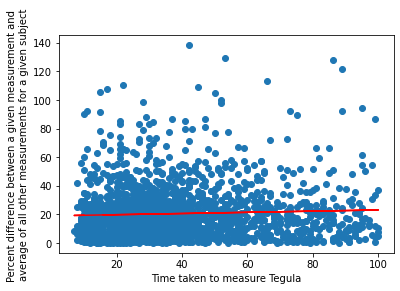

In [109]:
theta = np.polyfit(time, dissimilarity, 1)
y_line = theta[1] + theta[0] * np.array(time)

print(f'Slope of the best fit line: {theta[0]}')

pyplot.scatter(time, dissimilarity)
pyplot.xlabel('Time taken to measure Tegula')
pyplot.ylabel('Percent difference between a given measurement and \naverage of all other measurements for a given subject')
pyplot.plot(time, y_line, 'r')

Text(0, 0.5, 'Percent difference between a given measurement \nand average of all other measurements for a given subject')

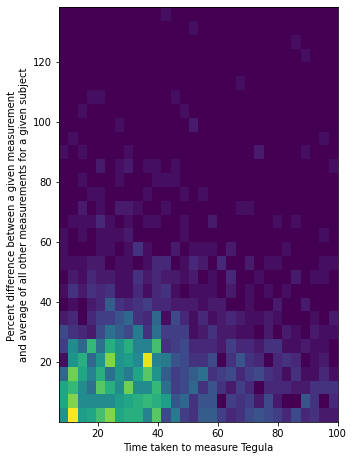

In [110]:
heatmap, xedges, yedges = np.histogram2d(time, dissimilarity, bins=30)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

fig, ax = pyplot.subplots(figsize=(5, 50))
ax.imshow(heatmap.T, extent=extent, origin='lower')
ax.set_xlabel('Time taken to measure Tegula')
ax.set_ylabel('Percent difference between a given measurement \nand average of all other measurements for a given subject')

Text(0, 0.5, 'Percent difference between a given measurement \nand average of all other measurements for a given subject')

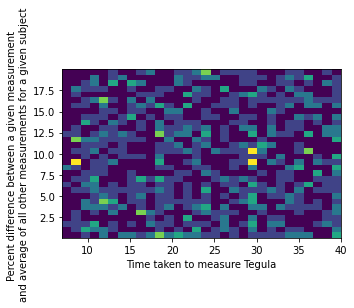

In [111]:
time_less_than_40 = []
dissimilarity_less_than_20 = []

for time_val, dissimilarity_val in zip(time,dissimilarity):
    if time_val<=40 and dissimilarity_val<=20:
        time_less_than_40.append(time_val)
        dissimilarity_less_than_20.append(dissimilarity_val)

heatmap, xedges, yedges = np.histogram2d(time_less_than_40, dissimilarity_less_than_20, bins=30)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

fig, ax = pyplot.subplots(figsize=(5, 50))
ax.imshow(heatmap.T, extent=extent, origin='lower')
ax.set_xlabel('Time taken to measure Tegula')
ax.set_ylabel('Percent difference between a given measurement \nand average of all other measurements for a given subject')

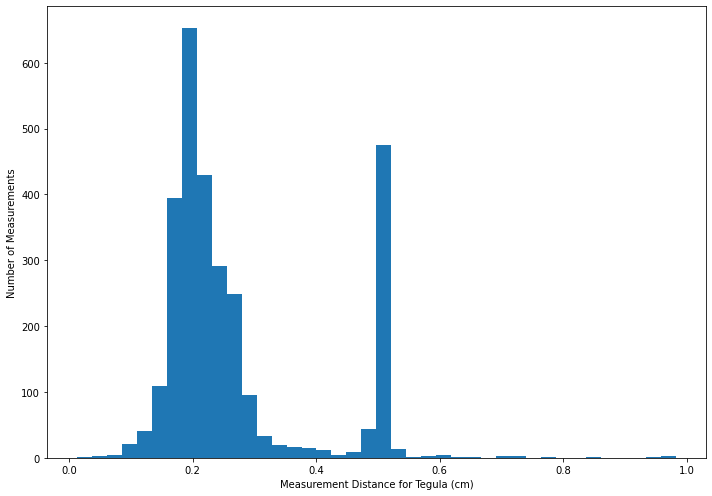

In [112]:
fig2, axs2 = pyplot.subplots(1, 1,
                        figsize =(10, 7),
                        tight_layout = True)
 
axs2.hist(tegula_distance_cm_array, bins = 40 )

axs2.set_ylabel('Number of Measurements')
axs2.set_xlabel('Measurement Distance for Tegula (cm)')

pyplot.show()

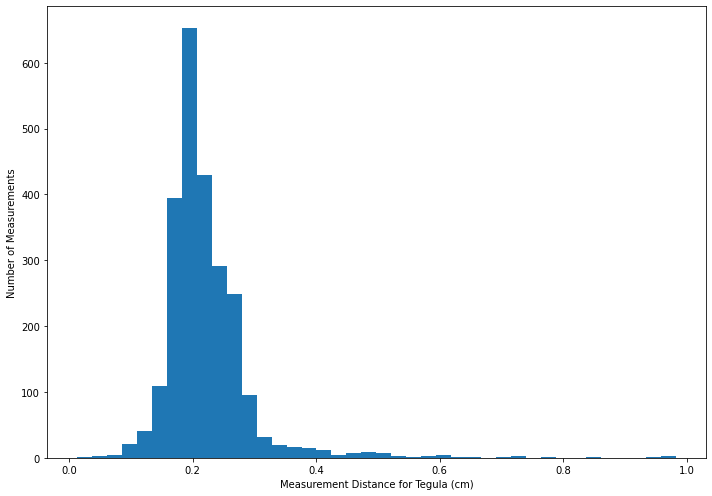

In [113]:
user_list = sheet.col_values(3)[1:]

tegula_distance_no_veronica = []

for user, distance in zip(user_list, tegula_distance_cm_array):
    if user != 'VeronicaGutierrez':
        tegula_distance_no_veronica.append(distance)
        
fig3, axs3 = pyplot.subplots(1, 1,
                        figsize =(10, 7),
                        tight_layout = True)

axs3.set_ylabel('Number of Measurements')
axs3.set_xlabel('Measurement Distance for Tegula (cm)')
 
axs3.hist(tegula_distance_no_veronica, bins = 40 )
pyplot.show()



In [114]:
with open("tegula_distance.csv", 'w') as f: 
    for number in tegula_distance_cm_array*1000: 
        f.write(f'{number}\n')

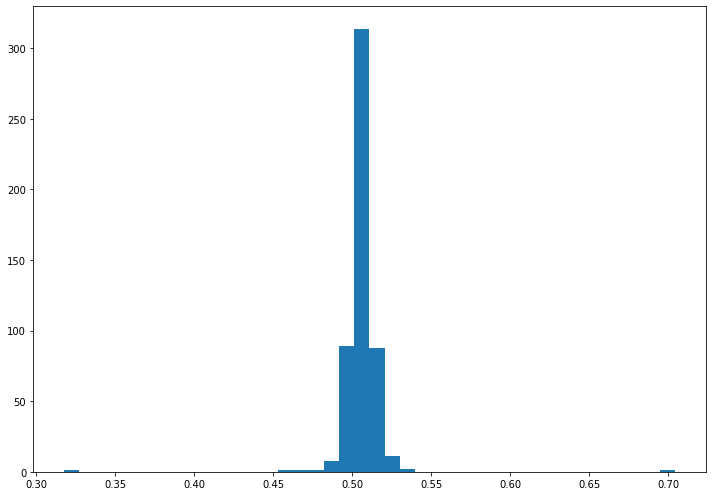

In [115]:
tegula_distance_only_veronica = []

for user, distance in zip(user_list, tegula_distance_cm_array):
    if user == 'VeronicaGutierrez':
        tegula_distance_only_veronica.append(distance)
        
fig3, axs3 = pyplot.subplots(1, 1,
                        figsize =(10, 7),
                        tight_layout = True)
 
axs3.hist(tegula_distance_only_veronica, bins = 40 )
pyplot.show()

Veronica Took 179.68085106382978 seconds to measure the Tegula distance on average.


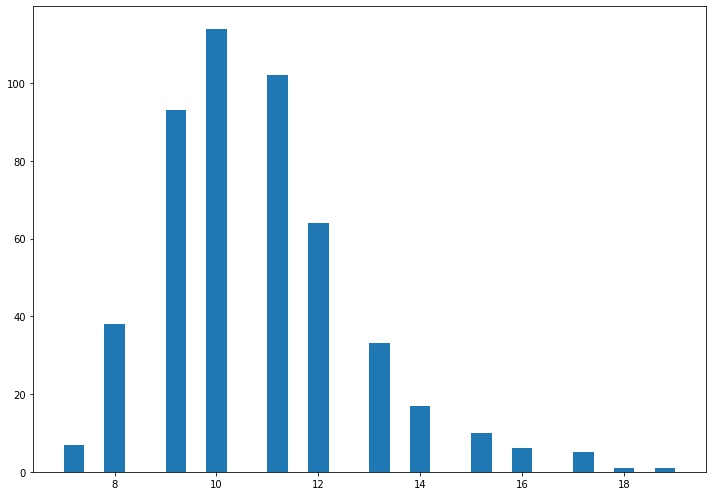

In [116]:
time_list = []
for start_time,finish_time in zip(time_started, time_finished):
    finish = datetime.datetime.strptime(finish_time, "%d-%b-%Y %H:%M:%S")
    start = datetime.datetime.strptime(start_time, "%d-%b-%Y %H:%M:%S")
    time_took = finish - start
    time_list.append(time_took.seconds)

measurement_time_only_veronica = []

for user, time in zip(user_list, time_list):
    if user == 'VeronicaGutierrez':
        measurement_time_only_veronica.append(time)

measurement_time_only_veronica = np.array(measurement_time_only_veronica)
measurement_time_only_veronica.sort()

print(f'Veronica Took {np.average(measurement_time_only_veronica)} seconds to measure the Tegula distance on average.')
        
fig4, axs4 = pyplot.subplots(1, 1,
                        figsize =(10, 7),
                        tight_layout = True)
 
axs4.hist(measurement_time_only_veronica[:int( 0.95*len(measurement_time_only_veronica) )], bins = 30 )
pyplot.show()

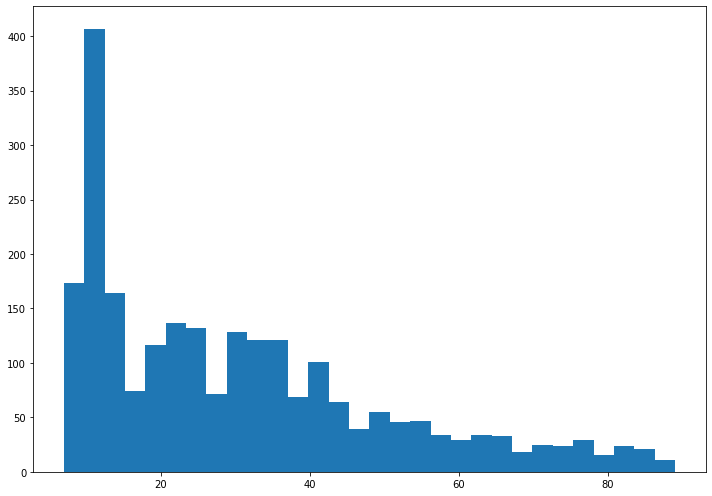

In [117]:
fig5, axs5 = pyplot.subplots(1, 1,
                        figsize =(10, 7),
                        tight_layout = True)

time_list = np.array(time_list)
time_list.sort()
 
axs5.hist(time_list[:int( 0.8*len(time_list) )], bins = 30 )
pyplot.show()

In [118]:
alec_data = client.open("imageJ-21776").get_worksheet(3)
alec_tms = alec_data.col_values(3)[1:]
alec_tms = [float(v) for v in alec_tms]
alec_tms = np.array(alec_tms)
alec_mt = alec_data.col_values(2)[1:]
alec_mt = [float(v) for v in alec_mt]
alec_mt = np.array(alec_mt)
alec_corrected = ( alec_mt / alec_tms ) * 0.5

emma_data = client.open("imageJ-21776").get_worksheet(4)
emma_tms = emma_data.col_values(3)[1:]
emma_tms = [float(v) for v in emma_tms]
emma_tms = np.array(emma_tms)
emma_mt = emma_data.col_values(2)[1:]
emma_mt = [float(v) for v in emma_mt]
emma_mt = np.array(emma_mt)
emma_corrected = ( emma_mt / emma_tms ) * 0.5

kaytlin_data = client.open("imageJ-21776").get_worksheet(5)
kaytlin_tms = kaytlin_data.col_values(3)[1:]
kaytlin_tms = [float(v[:-3]) for v in kaytlin_tms]
kaytlin_tms = np.array(kaytlin_tms)
kaytlin_mt = kaytlin_data.col_values(2)[1:]
kaytlin_mt = [float(v[:-3]) for v in kaytlin_mt]
kaytlin_mt = np.array(kaytlin_mt)
kaytlin_corrected = ( kaytlin_mt / kaytlin_tms ) * 0.5

luz_data = client.open("imageJ-21776").get_worksheet(6)
luz_tms = luz_data.col_values(3)[1:]
luz_tms = [float(v) for v in luz_tms]
luz_tms = np.array(luz_tms)
luz_mt = luz_data.col_values(2)[1:]
luz_mt = [float(v) for v in luz_mt]
luz_mt = np.array(luz_mt)
luz_corrected = ( luz_mt / luz_tms ) * 0.5

rosie_data = client.open("imageJ-21776").get_worksheet(7)
rosie_tms = rosie_data.col_values(3)[1:]
rosie_tms = [float(v) for v in rosie_tms]
rosie_tms = np.array(rosie_tms)
rosie_mt = rosie_data.col_values(2)[1:]
rosie_mt = [float(v) for v in rosie_mt]
rosie_mt = np.array(rosie_mt)
rosie_corrected = ( rosie_mt / rosie_tms ) * 0.5

filenames = client.open("imageJ-21776").get_worksheet(3).col_values(1)[1:]

In [119]:
researcher_std = []
researcher_std_uncorrected = []

for a,e,k,l,r in zip(alec_corrected, emma_corrected, kaytlin_corrected, luz_corrected, rosie_corrected):
    std = statistics.pstdev([a,e,k,l,r])
    researcher_std.append( std )

for a,e,k,l,r in zip(alec_mt, emma_mt, kaytlin_mt, luz_mt, rosie_mt):
    std = statistics.pstdev([a,e,k,l,r])
    researcher_std_uncorrected.append( std )

In [120]:
print(statistics.mean(researcher_std))
print(statistics.mean(researcher_std_uncorrected))

0.005650038356249638
0.005674400780798712


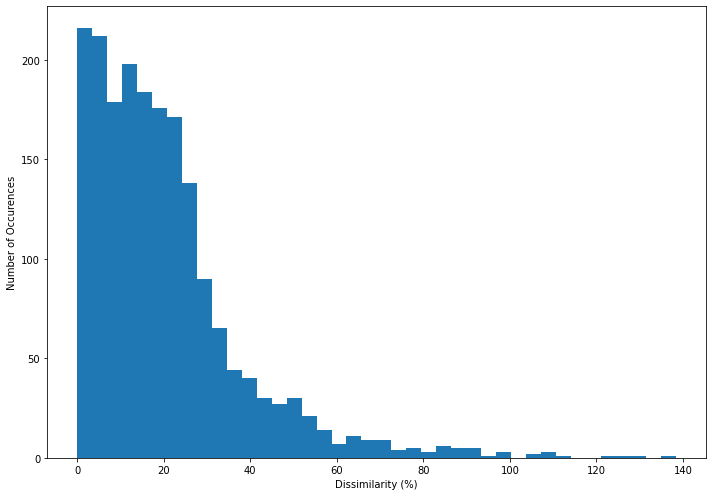

In [121]:
fig6, axs6 = pyplot.subplots(1, 1,
                        figsize =(10, 7),
                        tight_layout = True)
 
axs6.hist(dissimilarity, bins = 40 )
axs6.set_xlabel('Dissimilarity (%)')
axs6.set_ylabel('Number of Occurences')

pyplot.show()

In [122]:
dissimilarity_researchers = []

for a,k,l,r in zip(alec_corrected, kaytlin_corrected, luz_corrected, rosie_corrected):
    distance_list = [a,k,l,r]
    for distance_iter in range(0, len(distance_list)):
        distance = distance_list[distance_iter]
        other_distances = [distance_list[i] for i in range(len(distance_list)) if i != distance_iter]
        average_other_distance = statistics.mean(other_distances)
        percent_difference_distances = 100 * abs( average_other_distance - distance) / ( (average_other_distance + distance) / 2 )
        dissimilarity_researchers.append(percent_difference_distances)

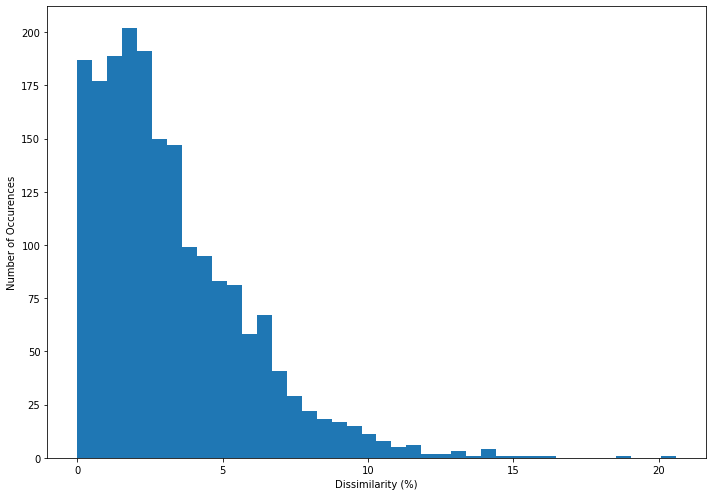

In [123]:
fig7, axs7 = pyplot.subplots(1, 1,
                        figsize =(10, 7),
                        tight_layout = True)
 
axs7.hist(dissimilarity_researchers, bins = 40 )
axs7.set_xlabel('Dissimilarity (%)')
axs7.set_ylabel('Number of Occurences')

pyplot.show()

3.2668836972921738
20.58652396475549

20.499947779278926
138.29764824244825


Text(0, 0.5, 'Number of Occurences')

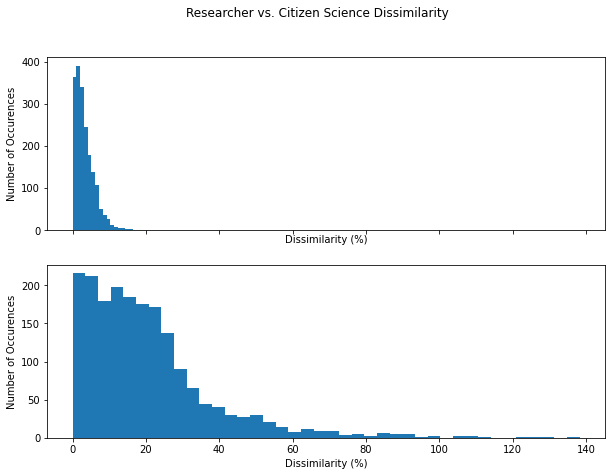

In [124]:
fig8, (axs8, axs9) = pyplot.subplots(2, figsize =(10, 7), sharex = True)

print(statistics.mean(dissimilarity_researchers))
print(max(dissimilarity_researchers))
print()
print(statistics.mean(dissimilarity))
print(max(dissimilarity))

fig8.suptitle('Researcher vs. Citizen Science Dissimilarity')

axs8.hist(dissimilarity_researchers, bins = 20 )
axs8.set_xlabel('Dissimilarity (%)')
axs8.set_ylabel('Number of Occurences')

axs9.hist(dissimilarity, bins = 40 )
axs9.set_xlabel('Dissimilarity (%)')
axs9.set_ylabel('Number of Occurences')

In [125]:
tegula_distance_comparison = defaultdict(list)

for subject_id, tegula_distance_cm, user in zip(subject_id_list, tegula_distance_cm_array, user_list):
    if user != 'VeronicaGutierrez':
        tegula_distance_comparison[ subject_id ].append(tegula_distance_cm)

In [126]:
tegula_distance_comparison_researchers = defaultdict(list)

for filename, a,k,l,r in zip(filenames, alec_corrected, kaytlin_corrected, luz_corrected, rosie_corrected):
    distance_list = [a,k,l,r]
    tegula_distance_comparison_researchers[ filename ] += distance_list

In [127]:
tegula_distance_comparison_side_by_side = defaultdict(list)

for key in tegula_distance_comparison_researchers:
    if key in tegula_distance_comparison:
        pos1 = tegula_distance_comparison[key]
        pos2 = tegula_distance_comparison_researchers[key]
        
        tegula_distance_comparison_side_by_side[key].append(pos1)
        tegula_distance_comparison_side_by_side[key].append(pos2)

In [128]:
percent_difference_pos_list = []
pos1_mean_list = []
pos2_mean_list = []
key_list = []

for key, value in tegula_distance_comparison_side_by_side.items():
    pos1_mean = statistics.mean(value[0])
    pos2_mean = statistics.mean(value[1])

    key_list.append(key)
    pos1_mean_list.append(pos1_mean)
    pos2_mean_list.append(pos2_mean)

    percent_difference_pos = 100 * abs( pos1_mean - pos2_mean) / ( (pos1_mean + pos2_mean) / 2 )
    
    percent_difference_pos_list.append(percent_difference_pos)

In [129]:
statistics.mean(percent_difference_pos_list)

13.681655517671683

Text(0, 0.5, '         Average Tegula Measurement for a Given Subject')

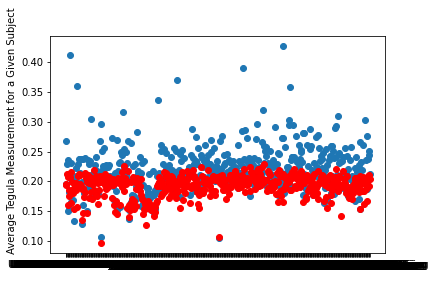

In [130]:
pyplot.scatter(key_list, pos1_mean_list)
pyplot.scatter(key_list, pos2_mean_list, color = 'r')
pyplot.ylabel('         Average Tegula Measurement for a Given Subject')


In [131]:
percent_diff_research_vs_cs2 = []
for r,cs in zip(pos1_mean_list, pos2_mean_list):
    percent_diff = 100 * abs(r - cs) / ( (r+cs)/2 )
    percent_diff_research_vs_cs2.append(percent_diff)
statistics.mean(percent_diff_research_vs_cs2)

13.681655517671683

In [132]:
import statistics
from scipy import stats

In [133]:
t_test_list = []

for key, value in tegula_distance_comparison_side_by_side.items():
    t_test = scipy.stats.ttest_ind(value[0], value[1])
    t_test_list.append(t_test[1])

In [134]:
sum (np.array(t_test_list) < 0.05)

19

In [135]:
len(t_test_list)

479

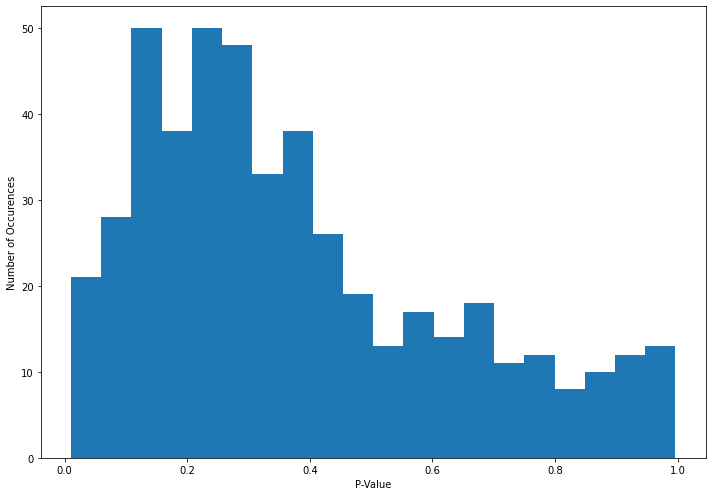

In [136]:
fig10, axs10 = pyplot.subplots(1, 1,
                        figsize =(10, 7),
                        tight_layout = True)
 
axs10.hist(t_test_list, bins = 20 )
axs10.set_xlabel('P-Value')
axs10.set_ylabel('Number of Occurences')

pyplot.show()

In [137]:
statistics.mean(t_test_list)

0.37819879381840016

In [138]:
data_by_user = defaultdict(list)

for column,value in enumerate(zip(subject_id_list, tegula_distance_cm_array, user_list)):
    subject_id = value[0]
    tegula_distance_cm = value[1]
    user = value[2]
    
    data_by_user[user].append(column)
    data_by_user[user].append(subject_id)
    data_by_user[user].append(tegula_distance_cm)

In [139]:
enumerated_val = defaultdict(list)

for column, value in enumerate(zip(subject_id_list, tegula_distance_cm_array,user_list)):
    subject_id = value[0]
    tegula_distance_cm = value[1]
    user = value[2]
    
    if user != 'VeronicaGutierrez':
        enumerated_val[ subject_id ].append(tegula_distance_cm)
        enumerated_val[ subject_id ].append(column)
    

dissimilarity_by_column = {}

for key,value in enumerated_val.items():
    for distance_iter in range(0, len(value), 2):
        distance = value[distance_iter]
        other_distances = [value[i] for i in range(len(value)) if i != distance_iter and i%2 == 0]
        average_other_distance = statistics.mean(other_distances)
        percent_difference_distances = 100 * abs( average_other_distance - distance) / ( (average_other_distance + distance) / 2 )

        column = value[distance_iter + 1]

        dissimilarity_by_column[column] = (percent_difference_distances)

In [140]:
dissimilarity_by_user = defaultdict(list)

for key,value in data_by_user.items():
    for column in range(0, len(value), 3):
        dissimilarity = dissimilarity_by_column[ column ]
        dissimilarity_by_user[key].append(dissimilarity)

In [141]:
avg_dissimilarity_by_user = defaultdict()
avg_dissimilarity_list = []

for key,value in dissimilarity_by_user.items():
    avg_dissimilarity_by_user[key] = statistics.mean(value)
    avg_dissimilarity_list.append(statistics.mean(value))

12.058596377466534


Text(0, 0.5, 'Number of Users who had this Average Score')

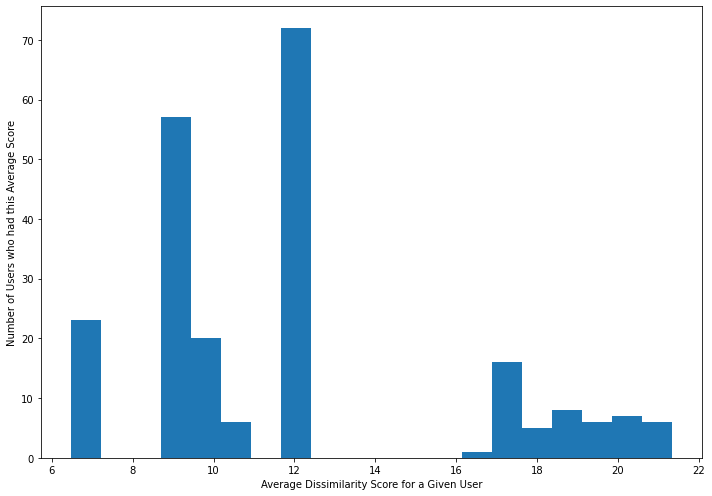

In [142]:
print(statistics.mean(avg_dissimilarity_list))

fig11, axs11 = pyplot.subplots(1,1, figsize = (10,7), tight_layout = True)
axs11.hist(avg_dissimilarity_list, bins = 20)
axs11.set_xlabel('Average Dissimilarity Score for a Given User')
axs11.set_ylabel('Number of Users who had this Average Score')

In [143]:
statistics.mean(dissimilarity_by_user['VeronicaGutierrez'])

18.5674602085464

In [144]:
l = defaultdict(int)
for user,subject_id in zip( sheet.col_values(3)[1:], sheet.col_values(1)[1:] ):
    l[subject_id] += 1
    if user == 'VeronicaGutierrez':
        break


In [145]:
y=[]
for k,v in l.items():
    y.append(v)

In [146]:
before_veronica = defaultdict(int)
for user,subject_id in zip( sheet.col_values(3)[1:], sheet.col_values(1)[1:] ):
    before_veronica[subject_id] += 1
    if user =='VeronicaGutierrez':
        break

after_veronica = defaultdict(int)
for user,subject_id in zip( sheet.col_values(3)[1:], sheet.col_values(1)[1:] ):
    after_veronica[subject_id] += 1

difference = []
after_veronica_list = []

for k,v in after_veronica.items():
    after_veronica_list.append(v)
    if before_veronica[k]==5:
        difference.append(v)

Text(0, 0.5, 'Number of Occurences for this Number of Measurements')

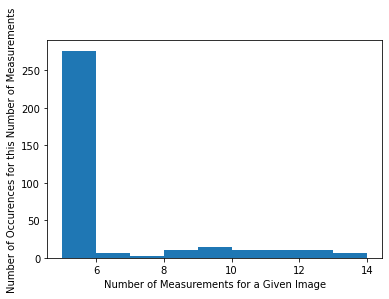

In [147]:
pyplot.hist(difference, bins=9)
pyplot.xlabel('Number of Measurements for a Given Image')
pyplot.ylabel('Number of Occurences for this Number of Measurements')

Text(0, 0.5, 'Number of Occurences for this Number of Measurements')

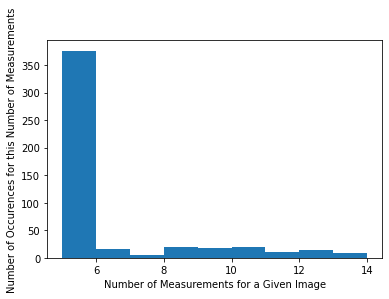

In [148]:
pyplot.hist(after_veronica_list, bins = 9)
pyplot.xlabel('Number of Measurements for a Given Image')
pyplot.ylabel('Number of Occurences for this Number of Measurements')

In [149]:
true_difference = []

after_veronica_list.sort()
for num in (set(after_veronica_list)):
    temp = after_veronica_list.count(num) - difference.count(num)
    true_difference.append(temp)

In [150]:
true_difference

[100, 9, 3, 8, 4, 10, 1, 5, 2, 0]

In [151]:
sum( np.array(difference) >5)

72

In [152]:
sum( np.array(after_veronica_list) >5)

114

In [153]:
scipy.stats.ttest_ind(pos1_mean_list, pos2_mean_list)

Ttest_indResult(statistic=14.831146151032744, pvalue=6.086865818719679e-45)

In [154]:
confidence_by_subject_id = defaultdict(float)
confidence_by_subject_id2 = defaultdict(float)

for s,c in zip(subject_id_list, confidence_list):
    if c == 'No':
        confidence_by_subject_id[s] += 1
    elif c == 'Yes':
        confidence_by_subject_id2[s] += 1

confidence_by_subject_id_list = [v for k,v in confidence_by_subject_id.items()]

In [155]:
x = []
y = []

for k,v in confidence_by_subject_id.items():
    x.append(v)
    y.append(confidence_by_subject_id2[k])

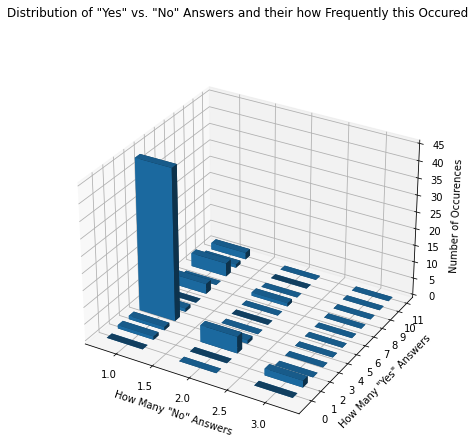

In [156]:
fig13 = pyplot.figure(figsize = (10,7))
ax13 = fig13.add_subplot(projection='3d')
hist, xedges, yedges = np.histogram2d(x, y, bins=[3,11], range=[[1, 4], [0, 12]])

# Construct arrays for the anchor positions of the 16 bars.
xpos, ypos = np.meshgrid(xedges[:-1] - 0.25, yedges[:-1] - 0.5, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

# Construct arrays with the dimensions for the 16 bars.
dx = dy = 0.5 * np.ones_like(zpos)
dz = hist.ravel()

fig13.suptitle('Distribution of "Yes" vs. "No" Answers and their how Frequently this Occured')

ax13.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')
ax13.set_yticks(range(12))
ax13.set_xlabel('How Many "No" Answers')
ax13.set_ylabel('How Many "Yes" Answers')
ax13.set_zlabel('Number of Occurences')

pyplot.show()

Text(0, 0.5, 'Number of Occurences')

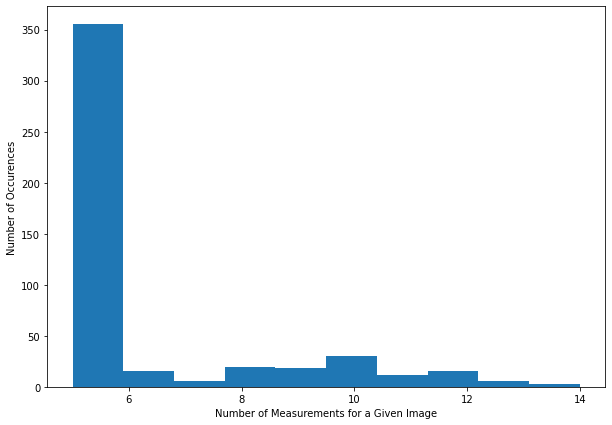

In [157]:
number_of_measurements = defaultdict(float)

for i in subject_id_list:
    number_of_measurements[i] += 1

number_of_measurements_list = [v for k,v in number_of_measurements.items()]

fig14,axs14 = pyplot.subplots(1,1,figsize = (10,7))
axs14.hist(number_of_measurements_list)
axs14.set_xlabel('Number of Measurements for a Given Image')
axs14.set_ylabel('Number of Occurences')

Text(0, 0.5, 'Number of Occurences')

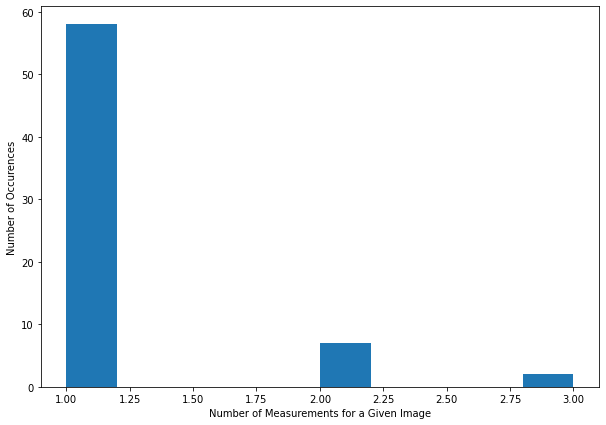

In [158]:
number_of_measurements_confidence = {}

for s,c in zip(subject_id_list,confidence_list):
    if s not in number_of_measurements_confidence:
        number_of_measurements_confidence[s] = [0,0]
    if c == 'Yes':
        number_of_measurements_confidence[s][0] +=1
    elif c == 'No':
        number_of_measurements_confidence[s][1] +=1


number_of_measurements_confidence2 = defaultdict(float)

for s,c in zip(subject_id_list,confidence_list):
    if c == 'No':
        number_of_measurements_confidence2[s] +=1

number_of_measurements_confidence2_list = [v for k,v in number_of_measurements_confidence2.items()]

fig17,axs17 = pyplot.subplots(1,1,figsize = (10,7))
axs17.hist(number_of_measurements_confidence2_list)
axs17.set_xlabel('Number of Measurements for a Given Image')
axs17.set_ylabel('Number of Occurences')

#show how many unconfident answers an image has vs how many total measurements it got

In [159]:
sum( np.array(number_of_measurements_list) > 5)

124

In [160]:
repeat_user_submissions = defaultdict(list)
repeat_user_submissions_score = defaultdict(float)

for s,u in zip(subject_id_list, user_list):
    repeat_user_submissions[s].append(u)

for k,v in repeat_user_submissions.items():
    set_v = set(v)
    for user in set_v:
        if v.count(user) > 1:
            repeat_user_submissions_score[k] += (v.count(user) - 1)

repeat_user_submissions_score_list = [v for k,v in repeat_user_submissions_score.items()]

3.177570093457944


Text(0, 0.5, 'Number of Occurences')

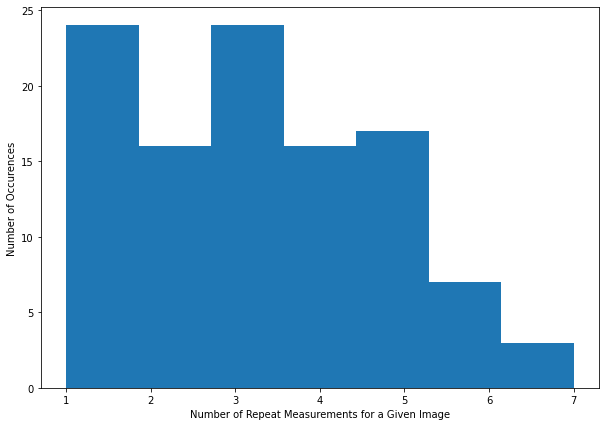

In [161]:
print(statistics.mean(repeat_user_submissions_score_list))

fig15,axs15 = pyplot.subplots(1,1,figsize = (10,7))
axs15.hist(repeat_user_submissions_score_list, bins = 7)
axs15.set_xlabel('Number of Repeat Measurements for a Given Image')
axs15.set_ylabel('Number of Occurences')

In [162]:
repeat_user_submissions = defaultdict(list)
repeat_user_submissions_score = defaultdict(float)

for s,u in zip(subject_id_list, user_list):
    if u != 'VeronicaGutierrez':
        repeat_user_submissions[s].append(u)

for k,v in repeat_user_submissions.items():
    set_v = set(v)
    for user in set_v:
        if v.count(user) > 1:
            repeat_user_submissions_score[k] += (v.count(user) - 1)

repeat_user_submissions_score_list = [v for k,v in repeat_user_submissions_score.items()]

Text(0, 0.5, 'Number of Occurences')

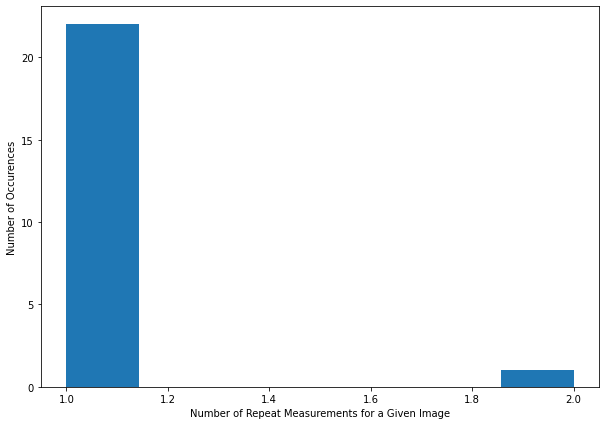

In [163]:
fig15,axs15 = pyplot.subplots(1,1,figsize = (10,7))
axs15.hist(repeat_user_submissions_score_list, bins = 7)
axs15.set_xlabel('Number of Repeat Measurements for a Given Image')
axs15.set_ylabel('Number of Occurences')

In [164]:
precise_measurements = defaultdict(list)

for s,t,u in zip(subject_id_list, tegula_distance_cm_array, user_list):
    if u != 'VeronicaGutierrez':
        precise_measurements[s].append(t)


precise_measurements_percent = defaultdict(list)
precise_measurements_percent_list = []
for k,v in precise_measurements.items():
    for num,measurement in enumerate(v):
        other_measurements = [m for m in v if m!=num]
        average_other_measurements = statistics.mean(other_measurements)
        percent_difference_measurements = 100 * abs( average_other_measurements - measurement) / ( (average_other_measurements + measurement) / 2 )

        if percent_difference_measurements < 40:
            precise_measurements_percent[k].append(measurement)

for k,v in precise_measurements_percent.items():
    for num,measurement in enumerate(v):
        other_measurements = [m for m in v if m!=num]
        average_other_measurements = statistics.mean(other_measurements)
        percent_difference_measurements = 100 * abs( average_other_measurements - measurement) / ( (average_other_measurements + measurement) / 2 )

        precise_measurements_percent_list.append(percent_difference_measurements)


precise_measurements_std = defaultdict(list)
precise_measurements_std_list = []
for k,v in precise_measurements.items():
    measurement_mean = statistics.mean(v)
    measurement_std = statistics.stdev(v)

    for measurement in v:
        if measurement > (measurement_mean - (1.5  * measurement_std) ) and measurement < (measurement_mean + (1.5  * measurement_std) ):
            precise_measurements_std[k].append(measurement)

for k,v in precise_measurements_std.items():
    for num,measurement in enumerate(v):
        other_measurements = [m for m in v if m!=num]
        average_other_measurements = statistics.mean(other_measurements)
        percent_difference_measurements = 100 * abs( average_other_measurements - measurement) / ( (average_other_measurements + measurement) / 2 )

        precise_measurements_std_list.append(percent_difference_measurements)


precise_measurements_both = defaultdict(list)
precise_measurements_both_list = []
for k,v in precise_measurements.items():

    measurement_mean = statistics.mean(v)
    measurement_std = statistics.stdev(v)

    for num,measurement in enumerate(v):
        other_measurements = [m for m in v if m!=num]
        average_other_measurements = statistics.mean(other_measurements)
        percent_difference_measurements = 100 * abs( average_other_measurements - measurement) / ( (average_other_measurements + measurement) / 2 )

        if percent_difference_measurements < 40 and measurement > (measurement_mean - 1.5 * measurement_std) and measurement < (measurement_mean + 1.5  * measurement_std):
            precise_measurements_both[k].append(measurement)

for k,v in precise_measurements_both.items():
    for num,measurement in enumerate(v):
        other_measurements = [m for m in v if m!=num]
        average_other_measurements = statistics.mean(other_measurements)
        percent_difference_measurements = 100 * abs( average_other_measurements - measurement) / ( (average_other_measurements + measurement) / 2 )

        precise_measurements_both_list.append(percent_difference_measurements)


precise_measurements_median = defaultdict(list)
precise_measurements_median_list = []
for k,v in precise_measurements.items():
    average_other_measurements = statistics.median(v)
    for measurement in v:
        percent_difference_measurements = 100 * abs( average_other_measurements - measurement) / ( (average_other_measurements + measurement) / 2 )

        if percent_difference_measurements < 40:
            precise_measurements_median[k].append(measurement)

for k,v in precise_measurements_median.items():
    for num,measurement in enumerate(v):
        other_measurements = [m for m in v if m!=num]
        average_other_measurements = statistics.mean(other_measurements)
        percent_difference_measurements = 100 * abs( average_other_measurements - measurement) / ( (average_other_measurements + measurement) / 2 )

        precise_measurements_median_list.append(percent_difference_measurements)


precise_measurements_both2 = defaultdict(list)
precise_measurements_both2_list = []
for k,v in precise_measurements.items():

    measurement_mean = statistics.mean(v)
    measurement_std = statistics.stdev(v)
    average_other_measurements = statistics.median(v)

    for num,measurement in enumerate(v):
        percent_difference_measurements = 100 * abs( average_other_measurements - measurement) / ( (average_other_measurements + measurement) / 2 )

        if percent_difference_measurements < 40 and measurement > (measurement_mean - 1.5 * measurement_std) and measurement < (measurement_mean + 1.5  * measurement_std):
            precise_measurements_both2[k].append(measurement)

for k,v in precise_measurements_both2.items():
    for num,measurement in enumerate(v):
        other_measurements = [m for m in v if m!=num]
        average_other_measurements = statistics.mean(other_measurements)
        percent_difference_measurements = 100 * abs( average_other_measurements - measurement) / ( (average_other_measurements + measurement) / 2 )

        precise_measurements_both2_list.append(percent_difference_measurements)

precise_measurements_both3 = defaultdict(list)
precise_measurements_both3_list = []
for k,v in precise_measurements.items():

    measurement_mean = statistics.mean(v)
    measurement_std = statistics.stdev(v)
    average_other_measurements2 = statistics.median(v)

    for num,measurement in enumerate(v):
        other_measurements = [m for m in v if m!=num]
        average_other_measurements = statistics.mean(other_measurements)
        percent_difference_measurements = 100 * abs( average_other_measurements - measurement) / ( (average_other_measurements + measurement) / 2 )
        percent_difference_measurements2 = 100 * abs( average_other_measurements2 - measurement) / ( (average_other_measurements2 + measurement) / 2 )

        if percent_difference_measurements < 40 and percent_difference_measurements2 < 40 and measurement > (measurement_mean - 1.5 * measurement_std) and measurement < (measurement_mean + 1.5  * measurement_std):
            precise_measurements_both3[k].append(measurement)

for k,v in precise_measurements_both3.items():
    for num,measurement in enumerate(v):
        other_measurements = [m for m in v if m!=num]
        average_other_measurements = statistics.mean(other_measurements)
        percent_difference_measurements = 100 * abs( average_other_measurements - measurement) / ( (average_other_measurements + measurement) / 2 )

        precise_measurements_both3_list.append(percent_difference_measurements)

In [165]:
#god the formatting on this is horrible, I don't know how to fix it

count = 0
super_dict = defaultdict(list)

for subject,measurement_list in precise_measurements.items():
    original_length = len(measurement_list)

    if subject not in precise_measurements_both3:
        count += 1

    for dictionary in [precise_measurements_percent, precise_measurements_std, precise_measurements_both, precise_measurements_median, precise_measurements_both2, precise_measurements_both3]:
        new_length = len(dictionary[subject])
        difference = original_length - new_length

        key = str(dictionary) #the bad formatting, do NOT print super_dict, all the keys are massive dictionaries themselves
        super_dict[key].append(difference)


In [166]:
precise_measurements_percent_hist = super_dict[str(precise_measurements_percent)]
precise_measurements_std_hist = super_dict[str(precise_measurements_std)]
precise_measurements_both_hist = super_dict[str(precise_measurements_both)]
precise_measurements_median_hist = super_dict[str(precise_measurements_median)]
precise_measurements_both2_hist = super_dict[str(precise_measurements_both2)]
precise_measurements_both3_hist = super_dict[str(precise_measurements_both3)]

In [167]:
sum(np.array(precise_measurements_median_hist) > 1)

24

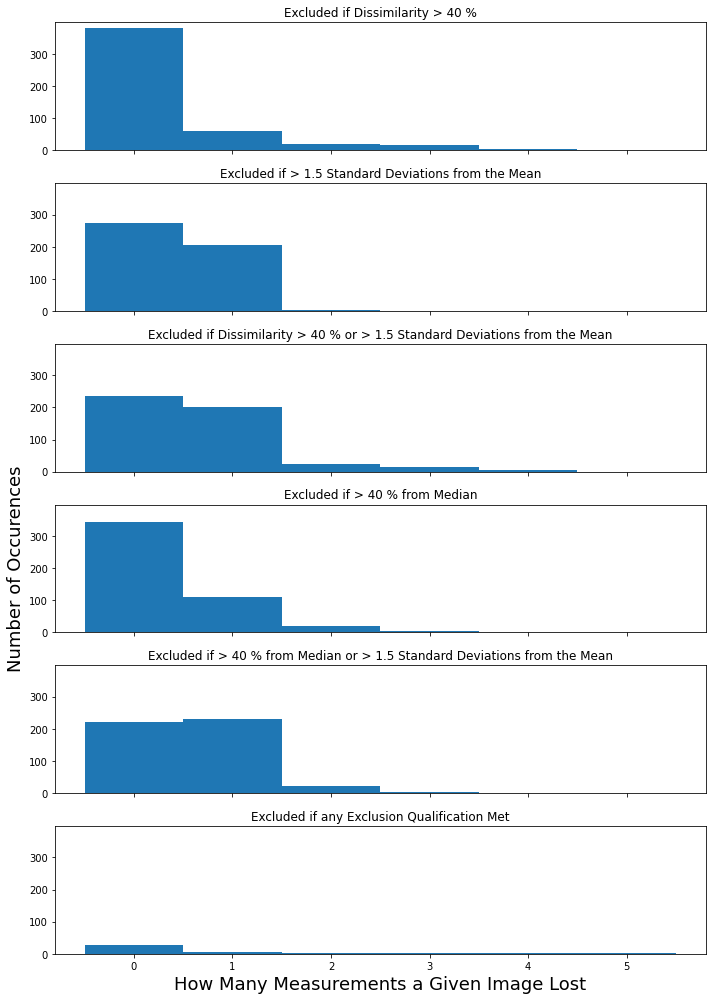

In [168]:
fig23, (axs23, axs24, axs25, axs26, axs27, axs28) = pyplot.subplots(6,1,
                            figsize = (10,14),
                            sharex = True,
                            sharey = True,
                            tight_layout = True)

axs23.hist(precise_measurements_percent_hist, bins = 6, range = (-0.5,5.5))
axs24.hist(precise_measurements_std_hist, bins = 6, range = (-0.5,5.5))
axs25.hist(precise_measurements_both_hist, bins = 6, range = (-0.5,5.5))
axs26.hist(precise_measurements_median_hist, bins = 6, range = (-0.5,5.5))
axs27.hist(precise_measurements_both2_hist, bins = 6, range = (-0.5,5.5))
axs28.hist(precise_measurements_both3_hist, bins = 6, range = (-0.5,5.5))

axs23.set_title('Excluded if Dissimilarity > 40 %')
axs24.set_title('Excluded if > 1.5 Standard Deviations from the Mean')
axs25.set_title('Excluded if Dissimilarity > 40 % or > 1.5 Standard Deviations from the Mean')
axs26.set_title('Excluded if > 40 % from Median')
axs27.set_title('Excluded if > 40 % from Median or > 1.5 Standard Deviations from the Mean')
axs28.set_title('Excluded if any Exclusion Qualification Met')

axs26.set_ylabel('Number of Occurences', fontsize = 18)
axs28.set_xlabel('How Many Measurements a Given Image Lost', fontsize = 18)

pyplot.show()

In [169]:
sum(np.array(precise_measurements_std_hist) > 1)

2

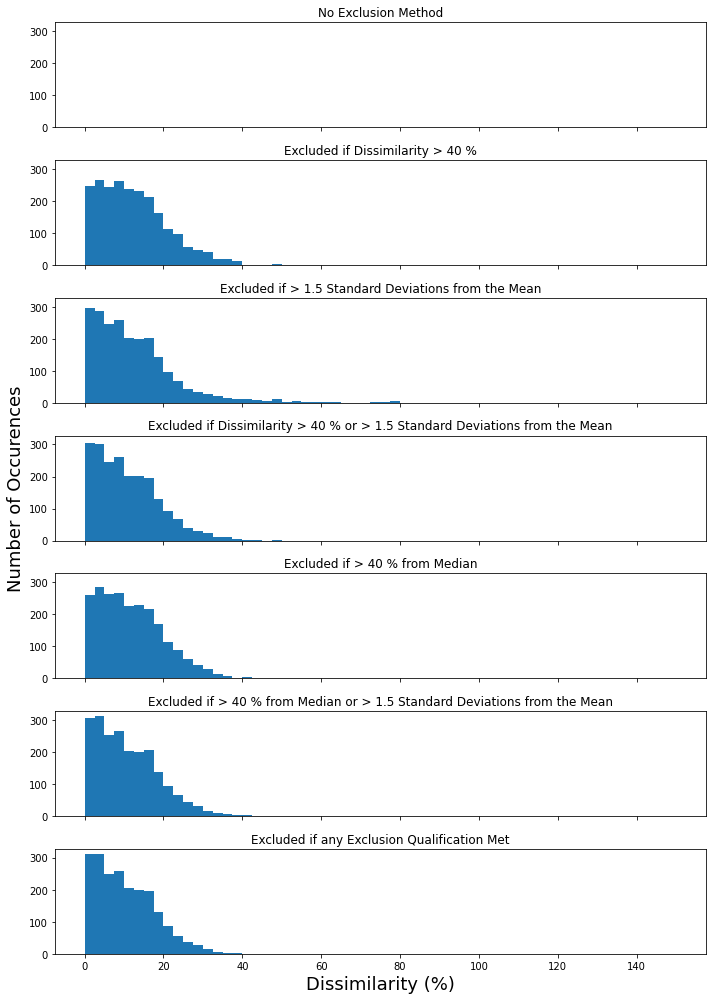

In [170]:
fig16, (axs15,axs16,axs17,axs18,axs19,axs20,axs21) = pyplot.subplots(7, 1,
                        figsize =(10, 14),
                        tight_layout = True,
                        sharex = True,
                        sharey = True)

axs15.hist(dissimilarity, bins = 60, range = (0,150) )
axs16.hist(precise_measurements_percent_list, bins = 60, range = (0,150) )
axs17.hist(precise_measurements_std_list, bins = 60, range = (0,150) )
axs18.hist(precise_measurements_both_list, bins = 60, range = (0,150) )
axs19.hist(precise_measurements_median_list, bins = 60, range = (0,150) )
axs20.hist(precise_measurements_both2_list, bins = 60, range = (0,150) )
axs21.hist(precise_measurements_both3_list, bins = 60, range = (0,150) )

axs18.set_ylabel('Number of Occurences', fontsize = 18)
axs21.set_xlabel('Dissimilarity (%)', fontsize = 18)

axs15.set_title('No Exclusion Method')
axs16.set_title('Excluded if Dissimilarity > 40 %')
axs17.set_title('Excluded if > 1.5 Standard Deviations from the Mean')
axs18.set_title('Excluded if Dissimilarity > 40 % or > 1.5 Standard Deviations from the Mean')
axs19.set_title('Excluded if > 40 % from Median')
axs20.set_title('Excluded if > 40 % from Median or > 1.5 Standard Deviations from the Mean')
axs21.set_title('Excluded if any Exclusion Qualification Met')

pyplot.show()

In [171]:
2096/2436

0.8604269293924466

Text(0, 0.5, 'Number of Data Points')

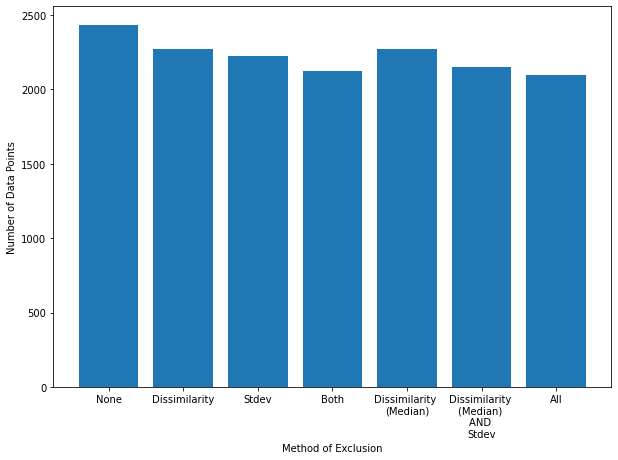

In [172]:
fig, axs22 = pyplot.subplots(1,1, figsize =(10,7))

axs22.bar(['None','Dissimilarity','Stdev','Both','Dissimilarity \n(Median)', 'Dissimilarity \n(Median) \nAND \nStdev', 'All'],[2436,len(precise_measurements_percent_list),len(precise_measurements_std_list),len(precise_measurements_both_list),len(precise_measurements_median_list), len(precise_measurements_both2_list), len(precise_measurements_both3_list)])
axs22.set_xlabel('Method of Exclusion')
axs22.set_ylabel('Number of Data Points')

In [173]:
data_by_user = defaultdict(list)

for column,value in enumerate(zip(subject_id_list, tegula_distance_cm_array, user_list)):
    subject_id = value[0]
    tegula_distance_cm = value[1]
    user = value[2]
    
    data_by_user[user].append(column)
    data_by_user[user].append(subject_id)
    data_by_user[user].append(tegula_distance_cm)



enumerated_val = defaultdict(list)

for column, value in enumerate(zip(subject_id_list, tegula_distance_cm_array,user_list)):
    subject_id = value[0]
    tegula_distance_cm = value[1]
    user = value[2]
    
    if user != 'VeronicaGutierrez':
        enumerated_val[ subject_id ].append(tegula_distance_cm)
        enumerated_val[ subject_id ].append(column)
    

dissimilarity_by_column_by_method = defaultdict(list)

for key,value in enumerated_val.items():

    if len(value) == 0:
        print('t')

    measurement_mean = statistics.mean(v)
    measurement_std = statistics.stdev(v)
    measurement_median = statistics.median(v)   

    for distance_iter in range(0, len(value), 2):
        distance = value[distance_iter]
        other_distances = [value[i] for i in range(len(value)) if i != distance_iter and i%2 == 0]
        average_other_distance = statistics.mean(other_distances)
        
        percent_difference_distances = 100 * abs( average_other_distance - distance) / ( (average_other_distance + distance) / 2 )
        percent_difference_median = 100 * abs( measurement_median - distance) / ( (measurement_median + distance) / 2 )
        z_score = (distance - measurement_mean) / measurement_std

        column = value[distance_iter + 1]

        dissimilarity_by_column_by_method[column].append(percent_difference_distances)
        dissimilarity_by_column_by_method[column].append(percent_difference_median)
        dissimilarity_by_column_by_method[column].append(z_score)

In [174]:
dissimilarity_by_column_by_method_by_user = defaultdict(list)

for col,user in enumerate(user_list):
    dissimilarity_by_method = dissimilarity_by_column_by_method[col]
    dissimilarity_by_column_by_method_by_user[user].append((col,dissimilarity_by_method))

In [175]:
percent_difference_distances_hist = defaultdict(list)
percent_difference_median_hist = defaultdict(list)
z_score_hist = defaultdict(list)

for user,list_2d in dissimilarity_by_column_by_method_by_user.items():
    for index, (col,given_list) in enumerate(list_2d):
        
        if len(given_list) != 0: #problematic user (VeronicaGutierrez) creates lists with len 0
            percent_difference_distances = given_list[0]
            percent_difference_median = given_list[1]
            z_score = given_list[2]

            percent_difference_distances_hist[index].append(percent_difference_distances)
            percent_difference_median_hist[index].append(percent_difference_median)
            z_score_hist[index].append(z_score)

In [176]:
x1,y1,y1_ave_list = [],[],[]
x2,y2,y2_ave_list = [],[],[]
x3,y3,y3_ave_list = [],[],[]

for k,v in percent_difference_distances_hist.items(): #scatter plot this and other 2 graphs
    temp_x = list(np.ones(len(v))*k)
    y1_ave = statistics.mean(v)

    x1 += temp_x
    y1 += v
    y1_ave_list.append(y1_ave)

for k,v in percent_difference_median_hist.items(): #scatter plot this and other 2 graphs
    temp_x = list(np.ones(len(v))*k)
    y2_ave = statistics.mean(v)

    x2 += temp_x
    y2 += v
    y2_ave_list.append(y2_ave)

for k,v in z_score_hist.items(): #scatter plot this and other 2 graphs
    temp_x = list(np.ones(len(v))*k)
    y3_ave = statistics.mean(v)

    x3 += temp_x
    y3 += v
    y3_ave_list.append(y3_ave)

#everything above 180 = one user

Text(0.5, 0, 'Contribution Index')

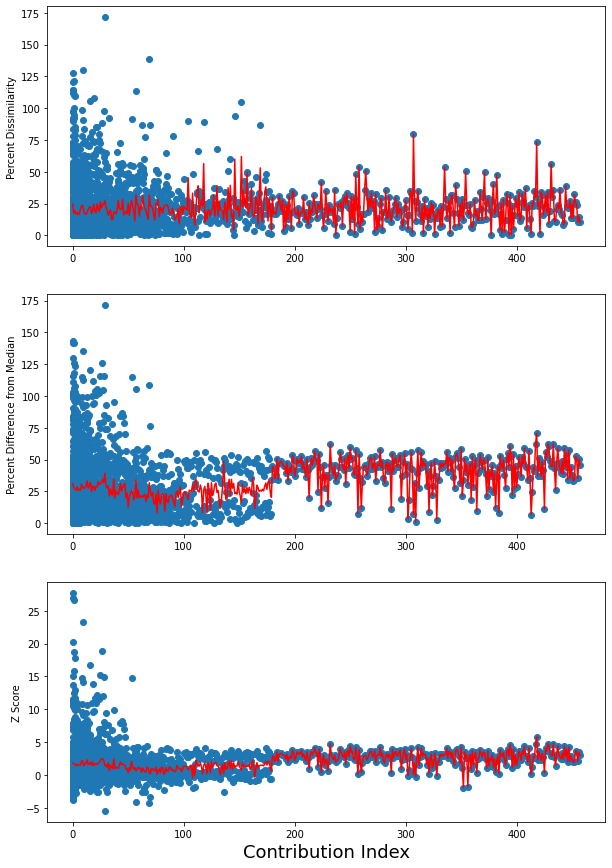

In [177]:
fig29,(axs29,axs30,axs31) = pyplot.subplots(3,1,
                    figsize = (10,15))

axs29.scatter(x1,y1)
axs30.scatter(x2,y2)
axs31.scatter(x3,y3)

axs29.plot([k for k,v in percent_difference_distances_hist.items()],y1_ave_list, color = 'r')
axs30.plot([k for k,v in percent_difference_median_hist.items()],y2_ave_list, color = 'r')
axs31.plot([k for k,v in z_score_hist.items()],y3_ave_list, color = 'r')

axs29.set_ylabel('Percent Dissimilarity')
axs30.set_ylabel('Percent Difference from Median')
axs31.set_ylabel('Z Score')

axs31.set_xlabel('Contribution Index', fontsize = 18)

Text(0.5, 0, 'Contribution Index')

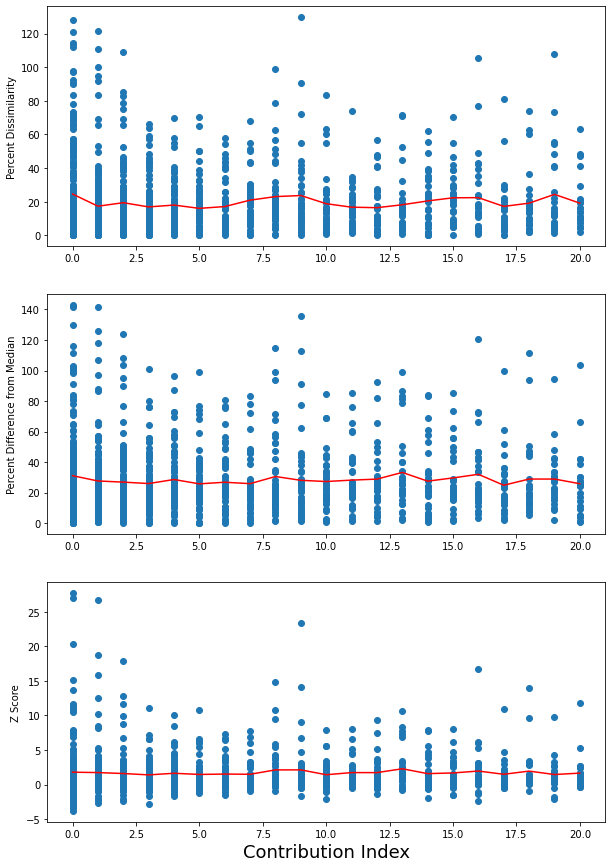

In [178]:
fig29,(axs29,axs30,axs31) = pyplot.subplots(3,1,
                    figsize = (10,15))



axs29.scatter(np.array(x1)[ np.where( np.array(x1) < 21 ) ],np.array(y1)[ np.where( np.array(x1) < 21 ) ])
axs30.scatter(np.array(x2)[ np.where( np.array(x2) < 21 ) ],np.array(y2)[ np.where( np.array(x2) < 21 ) ])
axs31.scatter(np.array(x3)[ np.where( np.array(x3) < 21 ) ],np.array(y3)[ np.where( np.array(x3) < 21 ) ])

axs29.plot([k for k,v in percent_difference_distances_hist.items()][:21],y1_ave_list[:21], color = 'r')
axs30.plot([k for k,v in percent_difference_median_hist.items()][:21],y2_ave_list[:21], color = 'r')
axs31.plot([k for k,v in z_score_hist.items()][:21],y3_ave_list[:21], color = 'r')

axs29.set_ylabel('Percent Dissimilarity')
axs30.set_ylabel('Percent Difference from Median')
axs31.set_ylabel('Z Score')

axs31.set_xlabel('Contribution Index', fontsize = 18)

In [179]:
number_of_contributions = []
temp_list = []

for k,v in percent_difference_distances_hist.items():
    contribution_number = len(v)
    temp_list.append(contribution_number)

temp_list.append(0)

for index,current_item in enumerate(temp_list):
    try:
        next_item = temp_list[index +1]
        difference = current_item - next_item
        difference_hist = list( np.ones(difference) * (index + 1) )
        number_of_contributions += difference_hist 
    except IndexError:
        break

Text(0, 0.5, 'Number of Occurences')

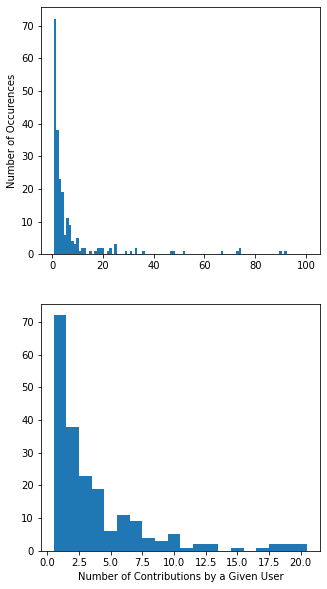

In [180]:
fig29,(axs29,axs30) = pyplot.subplots(2,1,
                    figsize = (5,10))

axs29.hist(number_of_contributions, range = (0.5, 100.5), bins = 100)
axs30.hist(number_of_contributions, range = (0.5, 20.5), bins = 20)

axs30.set_xlabel('Number of Contributions by a Given User')
axs29.set_ylabel('Number of Occurences')

In [181]:
sum(np.array(number_of_contributions) == 1)

72

In [182]:
statistics.mean(number_of_contributions)
#statistics.median(number_of_contributions)


10.778761061946902

In [183]:
for k,v in percent_difference_distances_hist.items():
    if len(v) == 1:
        print(k)
        break

180


In [184]:
reconciled_data = client.open("imageJ-21776").get_worksheet(1) 
subject_tegula_distance_list = defaultdict(list)
subject_tegula_distance_list_no_veronica = defaultdict(list)

for user,subject_id,tegula_distance in zip(user_list, subject_id_list, tegula_distance_cm_array):
    subject_tegula_distance_list[subject_id].append(tegula_distance)
    if user != 'VeronicaGutierrez':
        subject_tegula_distance_list_no_veronica[subject_id].append(tegula_distance)

subject_tegula_distance_ave = {}
for subject_id,list1 in subject_tegula_distance_list.items():
    ave = statistics.mean(list1)
    subject_tegula_distance_ave[subject_id] = ave

subject_tegula_distance_ave_no_veronica = {}
for subject_id,list2 in subject_tegula_distance_list_no_veronica.items():
    ave = statistics.mean(list2)
    subject_tegula_distance_ave_no_veronica[subject_id] = ave

In [185]:
subject_tegula_distance_ave_sorted = {}
subject_tegula_distance_ave_no_veronica_sorted = {}

reconciled_subjects = reconciled_data.col_values(17)[1:]

for subject_id in reconciled_subjects:
    sorted_val = subject_tegula_distance_ave[subject_id]
    sorted_val2 = subject_tegula_distance_ave_no_veronica[subject_id]

    subject_tegula_distance_ave_sorted[subject_id] = sorted_val
    subject_tegula_distance_ave_no_veronica_sorted[subject_id] = sorted_val2

In [186]:
with open("tegula_distance.csv", 'w') as f: 
    for subject_id in reconciled_subjects: 
        f.write(f'{subject_tegula_distance_ave_no_veronica_sorted[subject_id]},{subject_id}\n')

In [187]:
bs_temp_list = []
count = 0

self_percent_diff = []

their_reconcicled_tegula_distance = reconciled_data.col_values(7)[1:]
their_reconcicled_tegula_distance = [float(v) for v in their_reconcicled_tegula_distance]

for num,item in enumerate(reconciled_subjects):
    if item not in bs_temp_list:
        bs_temp_list.append(item)
    elif item in bs_temp_list:
        val1 = their_reconcicled_tegula_distance[num-1]
        val2 = their_reconcicled_tegula_distance[num]
        bs_temp_list.append(item)

        percent_difference = 100 * abs( val1 - val2) / ( (val1 + val2) / 2 )

        self_percent_diff.append(percent_difference)

Text(0, 0.5, 'Number of Occurences')

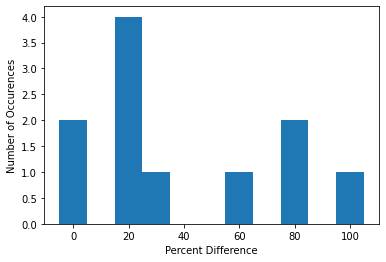

In [188]:
pyplot.hist(self_percent_diff, bins = 11, range = (-5,105))
pyplot.xlabel('Percent Difference')
pyplot.ylabel('Number of Occurences')

In [189]:
their_reconcicled_tegula_distance = reconciled_data.col_values(7)[1:]
their_reconcicled_tegula_distance = [float(v) for v in their_reconcicled_tegula_distance]

our_reconcicled_tegula_distance = reconciled_data.col_values(8)[1:]
our_reconcicled_tegula_distance = [float(v) for v in our_reconcicled_tegula_distance]

our_reconcicled_tegula_distance_no_veronica = reconciled_data.col_values(9)[1:]
our_reconcicled_tegula_distance_no_veronica = [float(v) for v in our_reconcicled_tegula_distance_no_veronica]

Text(0.5, 1.0, 'Our Reconciled Data (No Veronica)')

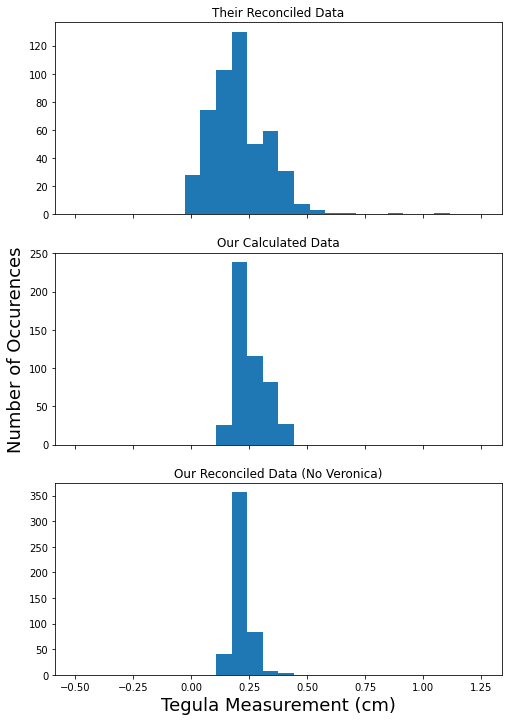

In [190]:
fig32,(axs32,axs33,axs34) = pyplot.subplots(3,1,
                                figsize = (8,12),
                                sharex = True)

bin_num = 26
bin_range = (-0.5,1.25)

axs32.hist(their_reconcicled_tegula_distance, bins = bin_num, range = bin_range)
axs33.hist(our_reconcicled_tegula_distance, bins = bin_num, range = bin_range)
axs34.hist(our_reconcicled_tegula_distance_no_veronica, bins = bin_num, range = bin_range)

axs33.set_ylabel('Number of Occurences', fontsize = 18)
axs34.set_xlabel('Tegula Measurement (cm)', fontsize = 18)

axs32.set_title('Their Reconciled Data')
axs33.set_title('Our Calculated Data')
axs34.set_title('Our Reconciled Data (No Veronica)')

In [191]:
#percent difference between our measurements and their measurements as a histogram

In [192]:
their_reconcicled_tegula_distance_array = np.array(their_reconcicled_tegula_distance)
our_reconcicled_tegula_distance_array = np.array(our_reconcicled_tegula_distance)
our_reconcicled_tegula_distance_no_veronica_array = np.array(our_reconcicled_tegula_distance_no_veronica)

In [193]:
reconciled_percent_diff_v = 100 * abs( their_reconcicled_tegula_distance_array - our_reconcicled_tegula_distance_array) / ( (their_reconcicled_tegula_distance_array + our_reconcicled_tegula_distance_array) / 2 )
reconciled_percent_diff_no_v = 100 * abs( their_reconcicled_tegula_distance_array - our_reconcicled_tegula_distance_no_veronica_array) / ( (their_reconcicled_tegula_distance_array + our_reconcicled_tegula_distance_no_veronica_array) / 2 )

Text(0.5, 0, 'Percent Difference Between Given Data and Reconciled Data')

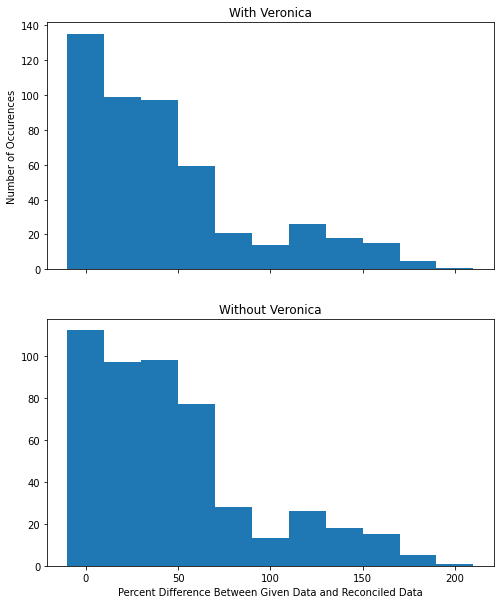

In [194]:
fig, (axs,axs2) = pyplot.subplots(2,1,
                    figsize = (8,10),
                    sharex = True)

bin_range = (-10,210)
bin_num = 11

axs.hist(reconciled_percent_diff_v, bins = bin_num, range = bin_range)
axs2.hist(reconciled_percent_diff_no_v, bins = bin_num, range = bin_range)

axs.set_title('With Veronica')
axs2.set_title('Without Veronica')

axs.set_ylabel('Number of Occurences')
axs2.set_xlabel('Percent Difference Between Given Data and Reconciled Data')

In [195]:
half_dist = defaultdict(list)

for subject,list1 in subject_tegula_distance_list_no_veronica.items():
    reciprocal_list = []
    for item1 in list1:
        reciprocal_list.append( 0.25 / item1) 
    for item1 in list1:
        for reciprocal1 in reciprocal_list:
            if item1 > (0.9 * reciprocal1) and item1 < (1.1 * reciprocal1):
                half_dist[subject].append(item1)

In [196]:
half_dist.values()
flat_list = [item for sublist in half_dist.values() for item in sublist]

Text(0, 0.5, 'Number of Occurences')

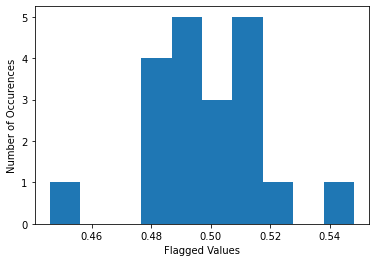

In [197]:
pyplot.hist(flat_list)
pyplot.xlabel('Flagged Values')
pyplot.ylabel('Number of Occurences')

In [198]:
coordinate_dict = defaultdict(list)
coordinate_dict2 = defaultdict(list)
coordinate_dict_ave = {}
coordinate_dict_ave2 = {}

for subject_id,x1,x2,y1,y2 in zip(subject_id_list,x1_val_list,x2_val_list,y1_val_list,y2_val_list):
    if subject_id == 'UCSB-IZC00038828.jpg':
        coordinate_dict['x1'].append(x1)
        coordinate_dict['x2'].append(x2)
        coordinate_dict['y1'].append(y1)
        coordinate_dict['y2'].append(y2)
    elif subject_id == 'UCSB-IZC00005623.jpg':
        coordinate_dict2['x1'].append(x1)
        coordinate_dict2['x2'].append(x2)
        coordinate_dict2['y1'].append(y1)
        coordinate_dict2['y2'].append(y2)

for k,v in coordinate_dict.items():
    coordinate_dict_ave[k] = statistics.mean(v)

for k,v in coordinate_dict2.items():
    coordinate_dict_ave[k] = statistics.mean(v)

Text(0, 0.5, 'Y-Coordinate')

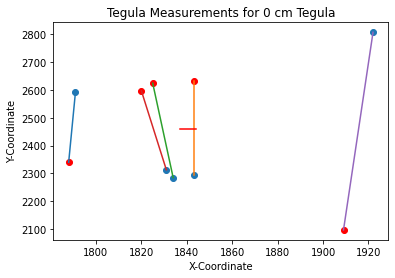

In [199]:
pyplot.scatter(coordinate_dict['x1'],coordinate_dict['y1'])
pyplot.scatter(coordinate_dict['x2'],coordinate_dict['y2'],c = 'r')
for x1,y1,x2,y2 in zip(coordinate_dict['x1'],coordinate_dict['y1'],coordinate_dict['x2'],coordinate_dict['y2']):
    pyplot.plot([x1,x2],[y1,y2])

pyplot.plot([statistics.mean(coordinate_dict['x1']),statistics.mean(coordinate_dict['x2'])],[statistics.mean(coordinate_dict['y1']),statistics.mean(coordinate_dict['y2'])], c = 'r')

pyplot.title('Tegula Measurements for 0 cm Tegula')
pyplot.xlabel('X-Coordinate')
pyplot.ylabel('Y-Coordinate')

Text(0, 0.5, 'Y-Coordinate')

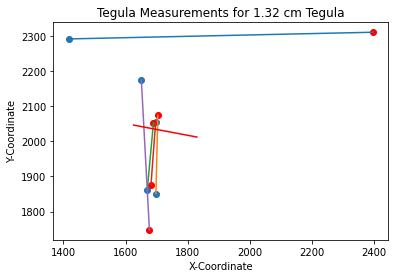

In [200]:
pyplot.scatter(coordinate_dict2['x1'],coordinate_dict2['y1'])
pyplot.scatter(coordinate_dict2['x2'],coordinate_dict2['y2'],c = 'r')
for x1,y1,x2,y2 in zip(coordinate_dict2['x1'],coordinate_dict2['y1'],coordinate_dict2['x2'],coordinate_dict2['y2']):
    pyplot.plot([x1,x2],[y1,y2])

pyplot.plot([statistics.mean(coordinate_dict2['x1']),statistics.mean(coordinate_dict2['x2'])],[statistics.mean(coordinate_dict2['y1']),statistics.mean(coordinate_dict2['y2'])], c = 'r')

pyplot.title('Tegula Measurements for 1.32 cm Tegula')
pyplot.xlabel('X-Coordinate')
pyplot.ylabel('Y-Coordinate')

In [201]:
coordinate_dict3 = defaultdict(list)
coordinate_dict4 = defaultdict(list)
coordinate_dict_ave = {}
coordinate_dict_ave2 = {}

for subject_id,x1,x2,y1,y2 in zip(subject_id_list,x1_scale_list,x2_scale_list,y1_scale_list,y2_scale_list):
    if subject_id == 'UCSB-IZC00038828.jpg':
        coordinate_dict3['x1'].append(x1)
        coordinate_dict3['x2'].append(x2)
        coordinate_dict3['y1'].append(y1)
        coordinate_dict3['y2'].append(y2)
    elif subject_id == 'UCSB-IZC00005623.jpg':
        coordinate_dict4['x1'].append(x1)
        coordinate_dict4['x2'].append(x2)
        coordinate_dict4['y1'].append(y1)
        coordinate_dict4['y2'].append(y2)

Text(0, 0.5, 'Y-Coordinate')

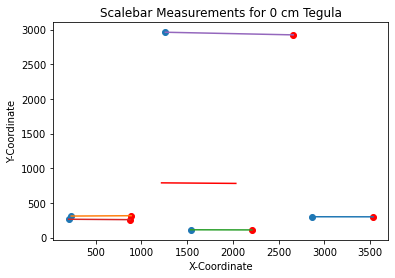

In [202]:
pyplot.scatter(coordinate_dict3['x1'],coordinate_dict3['y1'])
pyplot.scatter(coordinate_dict3['x2'],coordinate_dict3['y2'],c = 'r')
for x1,y1,x2,y2 in zip(coordinate_dict3['x1'],coordinate_dict3['y1'],coordinate_dict3['x2'],coordinate_dict3['y2']):
    pyplot.plot([x1,x2],[y1,y2])

pyplot.plot([statistics.mean(coordinate_dict3['x1']),statistics.mean(coordinate_dict3['x2'])],[statistics.mean(coordinate_dict3['y1']),statistics.mean(coordinate_dict3['y2'])], c = 'r')

pyplot.title('Scalebar Measurements for 0 cm Tegula')
pyplot.xlabel('X-Coordinate')
pyplot.ylabel('Y-Coordinate')

Text(0, 0.5, 'Y-Coordinate')

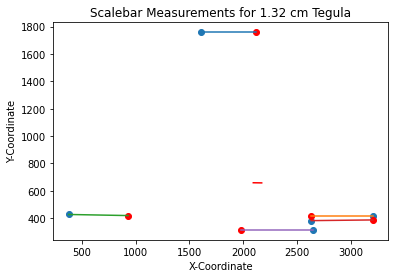

In [203]:
pyplot.scatter(coordinate_dict4['x1'],coordinate_dict4['y1'])
pyplot.scatter(coordinate_dict4['x2'],coordinate_dict4['y2'],c = 'r')
for x1,y1,x2,y2 in zip(coordinate_dict4['x1'],coordinate_dict4['y1'],coordinate_dict4['x2'],coordinate_dict4['y2']):
    pyplot.plot([x1,x2],[y1,y2])

pyplot.plot([statistics.mean(coordinate_dict4['x1']),statistics.mean(coordinate_dict4['x2'])],[statistics.mean(coordinate_dict4['y1']),statistics.mean(coordinate_dict4['y2'])], c = 'r')

pyplot.title('Scalebar Measurements for 1.32 cm Tegula')
pyplot.xlabel('X-Coordinate')
pyplot.ylabel('Y-Coordinate')

In [204]:
scale_by_subject_id = defaultdict(list)

for subject_id,user,scale_pixel in zip(subject_id_list,user_list,scale_pixel_distance):
    if user != 'VeronicaGutierrez':
        scale_by_subject_id[subject_id].append(scale_pixel)

In [205]:
outlier_scale_by_subject_id = defaultdict(list)

for k,v in scale_by_subject_id.items():
    for item1 in v:
        for item2 in v:
            if item2 > (1.8 * item1) and item2 < (2.2 * item1):
                outlier_scale_by_subject_id[k].append(item2)

for k,v in outlier_scale_by_subject_id.items():
    outlier_scale_by_subject_id[k] = set(v)

for k in list(outlier_scale_by_subject_id):
    if len(outlier_scale_by_subject_id[k]) > 2:
        del outlier_scale_by_subject_id[k]

scalebar_misread_list = []
for k,v in outlier_scale_by_subject_id.items():
    for item in v:
        scalebar_misread_list.append(item)

In [206]:
len(scalebar_misread_list)

67

In [207]:
#ways to identify bad measurement
#>0.4cm
#lack of accuracy measurements from earlier (test all)
#measured scalebar pixel distance >2x other ones

In [311]:
half_clean_data_by_subject_id = defaultdict(list)

for subject_id,user,tegula_distance,scale_distance in zip(subject_id_list,user_list,tegula_distance_cm_array,scale_pixel_distance):
    if user != 'VeronicaGutierrez':
        if tegula_distance < 0.4:
            if scale_distance not in outlier_scale_by_subject_id[subject_id]:
                half_clean_data_by_subject_id[subject_id].append(tegula_distance)

In [209]:
precise_measurements_percent = defaultdict(list)
precise_measurements_percent_list = []
half_clean_data_by_subject_id_list = []
for k,v in half_clean_data_by_subject_id.items():
    for num,measurement in enumerate(v):
        other_measurements = [m for m in v if m!=num]
        average_other_measurements = statistics.mean(other_measurements)
        percent_difference_measurements = 100 * abs( average_other_measurements - measurement) / ( (average_other_measurements + measurement) / 2 )

        half_clean_data_by_subject_id_list.append(percent_difference_measurements)
        if percent_difference_measurements < 40:
            precise_measurements_percent[k].append(measurement)

for k,v in precise_measurements_percent.items():
    for num,measurement in enumerate(v):
        other_measurements = [m for m in v if m!=num]
        average_other_measurements = statistics.mean(other_measurements)
        percent_difference_measurements = 100 * abs( average_other_measurements - measurement) / ( (average_other_measurements + measurement) / 2 )

        precise_measurements_percent_list.append(percent_difference_measurements)


precise_measurements_std = defaultdict(list)
precise_measurements_std_list = []
for k,v in half_clean_data_by_subject_id.items():
    measurement_mean = statistics.mean(v)
    measurement_std = statistics.stdev(v)

    for measurement in v:
        if measurement > (measurement_mean - (1.5  * measurement_std) ) and measurement < (measurement_mean + (1.5  * measurement_std) ):
            precise_measurements_std[k].append(measurement)

for k,v in precise_measurements_std.items():
    for num,measurement in enumerate(v):
        other_measurements = [m for m in v if m!=num]
        average_other_measurements = statistics.mean(other_measurements)
        percent_difference_measurements = 100 * abs( average_other_measurements - measurement) / ( (average_other_measurements + measurement) / 2 )

        precise_measurements_std_list.append(percent_difference_measurements)


precise_measurements_both = defaultdict(list)
precise_measurements_both_list = []
for k,v in half_clean_data_by_subject_id.items():

    measurement_mean = statistics.mean(v)
    measurement_std = statistics.stdev(v)

    for num,measurement in enumerate(v):
        other_measurements = [m for m in v if m!=num]
        average_other_measurements = statistics.mean(other_measurements)
        percent_difference_measurements = 100 * abs( average_other_measurements - measurement) / ( (average_other_measurements + measurement) / 2 )

        if percent_difference_measurements < 40 and measurement > (measurement_mean - 1.5 * measurement_std) and measurement < (measurement_mean + 1.5  * measurement_std):
            precise_measurements_both[k].append(measurement)

for k,v in precise_measurements_both.items():
    for num,measurement in enumerate(v):
        other_measurements = [m for m in v if m!=num]
        average_other_measurements = statistics.mean(other_measurements)
        percent_difference_measurements = 100 * abs( average_other_measurements - measurement) / ( (average_other_measurements + measurement) / 2 )

        precise_measurements_both_list.append(percent_difference_measurements)


precise_measurements_median = defaultdict(list)
precise_measurements_median_list = []
for k,v in half_clean_data_by_subject_id.items():
    average_other_measurements = statistics.median(v)
    for measurement in v:
        percent_difference_measurements = 100 * abs( average_other_measurements - measurement) / ( (average_other_measurements + measurement) / 2 )

        if percent_difference_measurements < 40:
            precise_measurements_median[k].append(measurement)

for k,v in precise_measurements_median.items():
    for num,measurement in enumerate(v):
        other_measurements = [m for m in v if m!=num]
        average_other_measurements = statistics.mean(other_measurements)
        percent_difference_measurements = 100 * abs( average_other_measurements - measurement) / ( (average_other_measurements + measurement) / 2 )

        precise_measurements_median_list.append(percent_difference_measurements)


precise_measurements_both2 = defaultdict(list)
precise_measurements_both2_list = []
for k,v in half_clean_data_by_subject_id.items():

    measurement_mean = statistics.mean(v)
    measurement_std = statistics.stdev(v)
    average_other_measurements = statistics.median(v)

    for num,measurement in enumerate(v):
        percent_difference_measurements = 100 * abs( average_other_measurements - measurement) / ( (average_other_measurements + measurement) / 2 )

        if percent_difference_measurements < 40 and measurement > (measurement_mean - 1.5 * measurement_std) and measurement < (measurement_mean + 1.5  * measurement_std):
            precise_measurements_both2[k].append(measurement)

for k,v in precise_measurements_both2.items():
    for num,measurement in enumerate(v):
        other_measurements = [m for m in v if m!=num]
        average_other_measurements = statistics.mean(other_measurements)
        percent_difference_measurements = 100 * abs( average_other_measurements - measurement) / ( (average_other_measurements + measurement) / 2 )

        precise_measurements_both2_list.append(percent_difference_measurements)


precise_measurements_both3 = defaultdict(list)
precise_measurements_both3_list = []
for k,v in half_clean_data_by_subject_id.items():

    measurement_mean = statistics.mean(v)
    measurement_std = statistics.stdev(v)
    average_other_measurements2 = statistics.median(v)

    for num,measurement in enumerate(v):
        other_measurements = [m for m in v if m!=num]
        average_other_measurements = statistics.mean(other_measurements)
        percent_difference_measurements = 100 * abs( average_other_measurements - measurement) / ( (average_other_measurements + measurement) / 2 )
        percent_difference_measurements2 = 100 * abs( average_other_measurements2 - measurement) / ( (average_other_measurements2 + measurement) / 2 )

        if percent_difference_measurements < 40 and percent_difference_measurements2 < 40 and measurement > (measurement_mean - 1.5 * measurement_std) and measurement < (measurement_mean + 1.5  * measurement_std):
            precise_measurements_both3[k].append(measurement)

for k,v in precise_measurements_both3.items():
    for num,measurement in enumerate(v):
        other_measurements = [m for m in v if m!=num]
        average_other_measurements = statistics.mean(other_measurements)
        percent_difference_measurements = 100 * abs( average_other_measurements - measurement) / ( (average_other_measurements + measurement) / 2 )

        precise_measurements_both3_list.append(percent_difference_measurements)

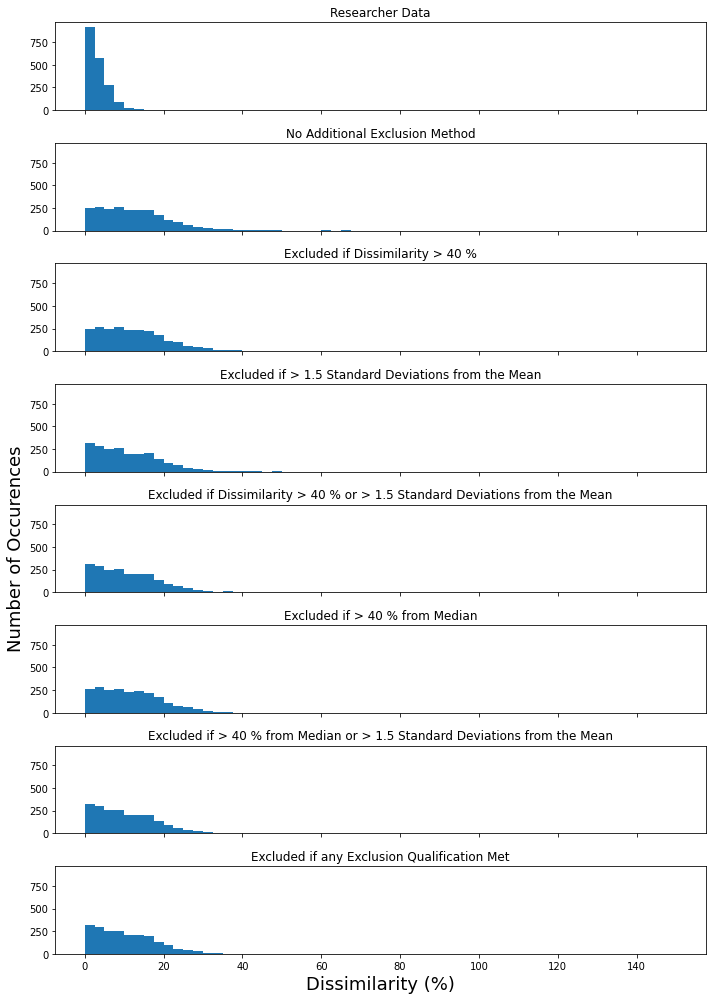

In [210]:
fig16, (axs14,axs15,axs16,axs17,axs18,axs19,axs20,axs21) = pyplot.subplots(8, 1,
                        figsize =(10, 14),
                        tight_layout = True,
                        sharex = True,
                        sharey = True)

axs14.hist(dissimilarity_researchers, bins = 60, range = (0,150))
axs15.hist(half_clean_data_by_subject_id_list, bins = 60, range = (0,150) )
axs16.hist(precise_measurements_percent_list, bins = 60, range = (0,150) )
axs17.hist(precise_measurements_std_list, bins = 60, range = (0,150) )
axs18.hist(precise_measurements_both_list, bins = 60, range = (0,150) )
axs19.hist(precise_measurements_median_list, bins = 60, range = (0,150) )
axs20.hist(precise_measurements_both2_list, bins = 60, range = (0,150) )
axs21.hist(precise_measurements_both3_list, bins = 60, range = (0,150) )

axs18.set_ylabel('Number of Occurences', fontsize = 18)
axs21.set_xlabel('Dissimilarity (%)', fontsize = 18)

axs14.set_title('Researcher Data')
axs15.set_title('No Additional Exclusion Method')
axs16.set_title('Excluded if Dissimilarity > 40 %')
axs17.set_title('Excluded if > 1.5 Standard Deviations from the Mean')
axs18.set_title('Excluded if Dissimilarity > 40 % or > 1.5 Standard Deviations from the Mean')
axs19.set_title('Excluded if > 40 % from Median')
axs20.set_title('Excluded if > 40 % from Median or > 1.5 Standard Deviations from the Mean')
axs21.set_title('Excluded if any Exclusion Qualification Met')

pyplot.show()

In [312]:
half_clean_data_by_subject_id = defaultdict(list)

for subject_id,user,tegula_distance,scale_distance in zip(subject_id_list,user_list,tegula_distance_cm_array,scale_pixel_distance):
    if user != 'VeronicaGutierrez':
        if tegula_distance < 0.4:
            if scale_distance not in outlier_scale_by_subject_id[subject_id]:
                half_clean_data_by_subject_id[subject_id].append(tegula_distance)

In [329]:
best_measurement_index_dict = defaultdict(list)

#tegula_distance_comparison_researchers

for k,value in half_clean_data_by_subject_id.items():
    v = [i for i in value]
    v.pop(int(np.random.rand()*len(v)))
    if len(v) > 1:
        v.sort()
    for index,measurement in enumerate(v):
        index_counter = 2
        
        indicator = 1
        while indicator == 1:
            if index + index_counter < len(v):
                cropped_v = v[index:index + index_counter]

                percent_difference_list = []
                for x, y in itertools.combinations(cropped_v, 2):
                    percent_difference = 100 * abs( x - y) / ( (x + y) / 2 )
                    if percent_difference > 3:
                        indicator = 0
                        break
                    else:
                        percent_difference_list.append(percent_difference)
                
                if indicator == 1:
                    best_measurement_index_dict[k] = [i for i in best_measurement_index_dict[k] if i[0] != index and i[1] - i[0] >= index_counter - index]
                    best_measurement_index_dict[k].append( (index,index + index_counter) ) if index + index_counter not in [i[1] for i in best_measurement_index_dict[k]] else 1+1

                index_counter += 1
                
            else:
                break

<BarContainer object of 4 artists>

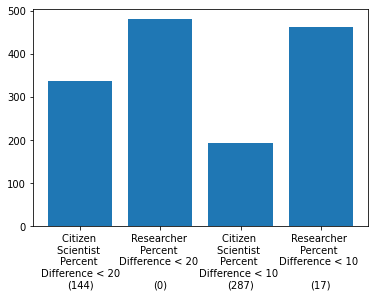

In [330]:
pyplot.bar(['Citizen \nScientist \nPercent \nDifference < 20\n(144)','Researcher \nPercent \nDifference < 20 \n\n(0)','Citizen \nScientist \nPercent \nDifference < 10 \n(287)','Researcher \nPercent \nDifference < 10 \n\n(17)'],[336,480,193,463])

In [331]:
best_measurement_dict = defaultdict(list)

for k,v in best_measurement_index_dict.items():
    sorted_v = half_clean_data_by_subject_id[k]
    sorted_v.sort

    best_average = []
    for tuple_var in v:
        index1 = tuple_var[0]
        index2 = tuple_var[1]
        values = sorted_v[index1:index2]
        values_ave = statistics.mean(values)
        best_average.append(values_ave)
    
    best_ave_index = best_average.index(max(best_average))
    best_tuple = v[best_ave_index]
    best_values = sorted_v[best_tuple[0]:best_tuple[1]]
    best_measurement_dict[k] = best_values

In [332]:
best_measurement_list = []
best_measurement_list_researcher = []
key_list2 = []
for k,v in best_measurement_dict.items():
    ave = statistics.mean(v)
    best_measurement_list.append(ave)

    ave2 = statistics.mean(tegula_distance_comparison_researchers[k])
    best_measurement_list_researcher.append(ave2)

    key_list2.append(k)

In [333]:
len(key_list2)

178

In [230]:
comp_val,comp_val2,key_list = [],[],[]

for k,v in distance_grouped_by_id_yes_and_no.items():
    comp_val.append( min(v) )
    comp_val2.append( statistics.mean(tegula_distance_comparison_researchers[k]) )
    key_list.append(k)

Text(0, 0.5, '         Average Tegula Measurement for a Given Subject')

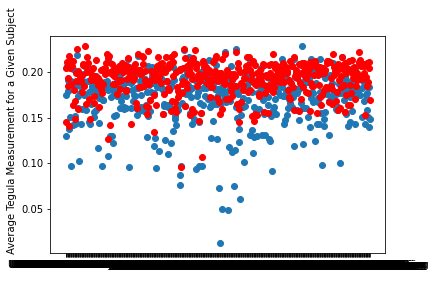

In [318]:
pyplot.scatter(key_list, comp_val)
pyplot.scatter(key_list, comp_val2, color = 'r')
pyplot.ylabel('         Average Tegula Measurement for a Given Subject')

In [321]:
len(key_list2)

340

Text(0, 0.5, '         Average Tegula Measurement for a Given Subject')

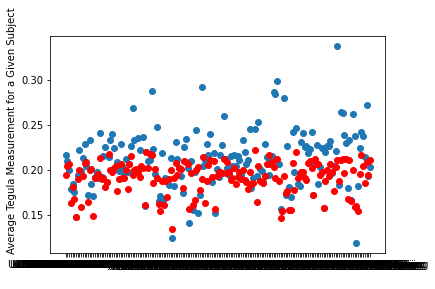

In [334]:
pyplot.scatter(key_list2, best_measurement_list)
pyplot.scatter(key_list2, best_measurement_list_researcher, color = 'r')
pyplot.ylabel('         Average Tegula Measurement for a Given Subject')


In [335]:
scipy.stats.ttest_ind(best_measurement_list, best_measurement_list_researcher)

Ttest_indResult(statistic=6.817069254433942, pvalue=4.019748845875073e-11)

In [380]:
percent_diff_research_vs_cs = []
for r,cs in zip(best_measurement_list, best_measurement_list_researcher):
    percent_diff = 100 * (r - cs) / ( (r+cs)/2 )
    percent_diff_research_vs_cs.append(percent_diff)

In [381]:
statistics.mean(percent_diff_research_vs_cs)

2.0858808583619286

In [368]:
iter_var = 0
while scipy.stats.ttest_ind(best_measurement_list, best_measurement_list_researcher)[1] < 0.05:

    best_measurement_index_dict = defaultdict(list)

    for k,v in half_clean_data_by_subject_id.items():
        v.sort()
        for index,measurement in enumerate(v):
            index_counter = 3
            
            indicator = 1
            while indicator == 1:
                if index + index_counter < len(v):
                    cropped_v = v[index:index + index_counter]

                    percent_difference_list = []
                    for x, y in itertools.combinations(cropped_v, 2):
                        percent_difference = 100 * abs( x - y) / ( (x + y) / 2 )
                        if percent_difference > 10 - iter_var:
                            indicator = 0
                            break
                        else:
                            percent_difference_list.append(percent_difference)
                    
                    if indicator == 1:
                        best_measurement_index_dict[k] = [i for i in best_measurement_index_dict[k] if i[0] != index and i[1] - i[0] >= index_counter - index]
                        best_measurement_index_dict[k].append( (index,index + index_counter) ) if index + index_counter not in [i[1] for i in best_measurement_index_dict[k]] else 1+1

                    index_counter += 1
                    
                else:
                    break

    best_measurement_dict = defaultdict(list)

    for k,v in best_measurement_index_dict.items():
        sorted_v = half_clean_data_by_subject_id[k]
        sorted_v.sort

        best_average = []
        for tuple_var in v:
            index1 = tuple_var[0]
            index2 = tuple_var[1]
            values = sorted_v[index1:index2]
            values_ave = statistics.mean(values)
            best_average.append(values_ave)
        
        best_ave_index = best_average.index(max(best_average))
        best_tuple = v[best_ave_index]
        best_values = sorted_v[best_tuple[0]:best_tuple[1]]
        best_measurement_dict[k] = best_values

    best_measurement_list = []
    best_measurement_list_researcher = []
    key_list2 = []
    for k,v in best_measurement_dict.items():
        ave = statistics.mean(v)
        best_measurement_list.append(ave)

        ave2 = statistics.mean(tegula_distance_comparison_researchers[k])
        best_measurement_list_researcher.append(ave2)

        key_list2.append(k)

    print(scipy.stats.ttest_ind(best_measurement_list, best_measurement_list_researcher)[1], iter_var, len(best_measurement_list),'\r')
    iter_var += 0.01

0.03308475681585503 0 193 
0.03630341657854737 0.01 192 
0.035950471583723484 0.02 191 
0.035950471583723484 0.03 191 
0.035950471583723484 0.04 191 
0.035950471583723484 0.05 191 
0.03749192862137623 0.060000000000000005 191 
0.03749192862137623 0.07 191 
0.03809347122866301 0.08 191 
0.037793258585577374 0.09 191 
0.037793258585577374 0.09999999999999999 191 
0.037793258585577374 0.10999999999999999 191 
0.037793258585577374 0.11999999999999998 191 
0.037793258585577374 0.12999999999999998 191 
0.038203269260083446 0.13999999999999999 190 
0.038203269260083446 0.15 190 
0.04203694258755043 0.16 189 
0.04203226828074796 0.17 188 
0.044623020761832936 0.18000000000000002 188 
0.045789920695025826 0.19000000000000003 186 
0.045789920695025826 0.20000000000000004 186 
0.045789920695025826 0.21000000000000005 186 
0.045789920695025826 0.22000000000000006 186 
0.04531062811652143 0.23000000000000007 186 
0.044947539367364585 0.24000000000000007 185 
0.044947539367364585 0.25000000000000006

In [399]:
mistake_by_user = defaultdict(int)
mistake_by_user2 = defaultdict(int)
mistake_by_user3 = defaultdict(int)

for subject_id,user,tegula_distance,scale_distance in zip(subject_id_list,user_list,tegula_distance_cm_array,scale_pixel_distance):
    if user != 'VeronicaGutierrez':
        if tegula_distance > 0.4:
            mistake_by_user2[user] += 1
        if scale_distance in outlier_scale_by_subject_id[subject_id]:
            mistake_by_user[user] += 1

In [401]:
sum([v for k,v in mistake_by_user2.items()])

62

Text(0, 0.5, 'How many Users made this Number of Mistakes')

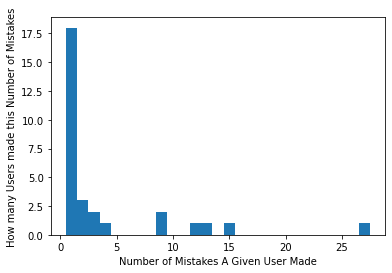

In [392]:
pyplot.hist([v for k,v in mistake_by_user.items()], bins = 27, range = (0.5,27.5) )
pyplot.xlabel('Number of Mistakes A Given User Made')
pyplot.ylabel('How many Users made this Number of Mistakes')

In [396]:
count = 0
count2 = 0
for k,v in mistake_by_user.items():
    if k[:13] == 'not-logged-in':
        count += 1
        count2 += v

In [398]:
count2

27

In [409]:
list1 = [1,2,3,4]
list2 = [5,6,7,8]
list3 = [9,10,11,12]

def test(*lists):
    print(len([*lists]))
    for tuple in zip(*lists):
        print(tuple)

In [410]:
test(list1,list2,list3)

3
(1, 5, 9)
(2, 6, 10)
(3, 7, 11)
(4, 8, 12)


In [411]:
microscope_measurements = client.open("Summer 2022 Microscope Measurments")

In [478]:
alec_mm = microscope_measurements.get_worksheet(0)
alec_mm_dict = {k:float(v) for k,v in zip( alec_mm.col_values(1)[1:],alec_mm.col_values(2)[1:] ) if len(v) > 0}
issue_dict = defaultdict(list)

for sheet_number in [3,4,5]:
    worksheet = microscope_measurements.get_worksheet(sheet_number)
    worksheet_mm_dict = {k:float(v) for k,v in zip( worksheet.col_values(1)[1:],worksheet.col_values(2)[1:] ) if v != '---' and v != 'REMOVE FROM STUDY' and v != 'Lasioglossum' and len(v) > 0}
    for k,v in alec_mm_dict.items():
        try:
            if abs(worksheet_mm_dict[k] - v) > 0.4:
                print(k, worksheet.title)
                issue_dict[k].append((worksheet_mm_dict[k],worksheet.title))
        except KeyError:
            try:
                if abs(worksheet_mm_dict[k[:-4]] - v) > 0.4:
                    print(k, worksheet.title)
                    issue_dict[k].append((worksheet_mm_dict[k],worksheet.title))
            except KeyError:
                try:
                    if abs(worksheet_mm_dict[k + '.jpg'] - v) > 0.4:
                        print(k, worksheet.title)
                        issue_dict[k].append((worksheet_mm_dict[k],worksheet.title))
                except:
                    pass

for key in issue_dict:
    issue_dict[key].append((alec_mm_dict[key], 'Alec'))

UCSB-IZC00005919.jpg Luz
UCSB-IZC00036169.jpg Luz
UCSB-IZC00036625 Kaytlin
UCSB-IZC00036646.jpg Kaytlin
UCSB-IZC00039774 Rosie
UCSB-IZC00012445.jpg Rosie
UCSB-IZC00041535.jpg Rosie


In [486]:
alec_mm = microscope_measurements.get_worksheet(0)
alec_mm_dict = {k:float(v) for k,v in zip( alec_mm.col_values(1)[1:],alec_mm.col_values(2)[1:] ) if len(v) > 0}
issue_dict2 = defaultdict(list)
worksheet_dict = {iter_sheet:microscope_measurements.get_worksheet(iter_sheet) for iter_sheet in [0,3,4,5]}

for combination in itertools.combinations([0,3,4,5],2):
    worksheet1 = worksheet_dict[combination[0]]
    worksheet2 = worksheet_dict[combination[1]]
    print(worksheet1.title,worksheet2.title)
    worksheet_mm_dict1 = {k:float(v) for k,v in zip( worksheet1.col_values(1)[1:],worksheet1.col_values(2)[1:] ) if v != '---' and v != 'REMOVE FROM STUDY' and v != 'Lasioglossum' and len(v) > 0}
    worksheet_mm_dict2 = {k:float(v) for k,v in zip( worksheet2.col_values(1)[1:],worksheet2.col_values(2)[1:] ) if v != '---' and v != 'REMOVE FROM STUDY' and v != 'Lasioglossum' and len(v) > 0}
    for k,v in worksheet_mm_dict1.items():
        try:
            if abs(worksheet_mm_dict2[k] - v) > 0.4:
                issue_dict2[k + '_' + worksheet1.title].append((worksheet_mm_dict2[k],worksheet2.title))
                issue_dict2[k + '_' + worksheet1.title].append(v)
        except KeyError:
            try:
                if abs(worksheet_mm_dict2[k] - v) > 0.4:
                    issue_dict2[k + '_' + worksheet1.title].append((worksheet_mm_dict2[k],worksheet2.title))
                    issue_dict2[k + '_' + worksheet1.title].append(v)
            except KeyError:
                try:
                    if abs(worksheet_mm_dict2[k] - v) > 0.4:
                        issue_dict2[k + '_' + worksheet1.title].append((worksheet_mm_dict2[k],worksheet2.title))
                        issue_dict2[k + '_' + worksheet1.title].append(v)
                except:
                    pass

Alec Luz
Alec Kaytlin
Alec Rosie
Luz Kaytlin
Luz Rosie
Kaytlin Rosie


In [487]:
issue_dict2

defaultdict(list,
            {'UCSB-IZC00005919.jpg_Alec': [(1.4, 'Luz'), 1.8],
             'UCSB-IZC00036169.jpg_Alec': [(2.1, 'Luz'), 1.7],
             'UCSB-IZC00036625_Alec': [(1.8, 'Kaytlin'), 2.2],
             'UCSB-IZC00036646.jpg_Alec': [(2.2, 'Kaytlin'), 1.8],
             'UCSB-IZC00039774_Alec': [(2.1, 'Rosie'), 1.6],
             'UCSB-IZC00012445.jpg_Alec': [(1.7, 'Rosie'), 2.1],
             'UCSB-IZC00041535.jpg_Alec': [(1.8, 'Rosie'), 2.2],
             'UCSB-IZC00036646.jpg_Luz': [(2.2, 'Kaytlin'), 1.7],
             'UCSB-IZC00039774_Luz': [(2.1, 'Rosie'), 1.6],
             'UCSB-IZC00043039.jpg_Luz': [(1.4, 'Rosie'), 1.9],
             'UCSB-IZC00012329.jpg_Luz': [(1.7, 'Rosie'), 2.1],
             'UCSB-IZC00005919.jpg_Luz': [(1.8, 'Rosie'), 1.4],
             'UCSB-IZC00036017.jpg_Kaytlin': [(2.0, 'Rosie'), 1.5],
             'UCSB-IZC00039774_Kaytlin': [(2.1, 'Rosie'), 1.6],
             'UCSB-IZC00043039.jpg_Kaytlin': [(1.4, 'Rosie'), 1.8]})

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import statistics

In [240]:
def percent_difference(input_array,step):
    count = 0
    input_array = np.sort(input_array)
    for combo in range(len(input_array)-step+1):
        percent_diff = 100 * abs( abs(input_array[combo] - input_array[combo+step-1]) / ( (input_array[combo] + input_array[combo+step-1]) / 2 ) )
        if percent_diff < 10:
            count += 1
    return count

In [262]:
step_size = 3
simulation_number = 100000

simulation_array = np.random.normal(0.212,0.0469,(simulation_number,4))
percent_difference_list = []

for item in simulation_array:
    percent_difference_list.append( percent_difference(item,step_size) )

count_array = np.array(percent_difference_list)

In [264]:
sum(count_array==0)

82281

(array([16290., 44920., 32632.,  6158.,     0.,     0.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5]),
 <BarContainer object of 6 artists>)

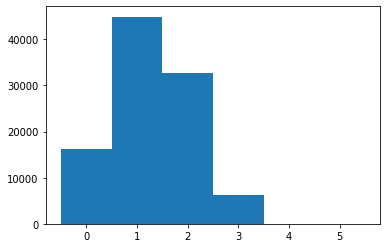

In [261]:
plt.hist(count_array, bins = 6, range = (-0.5,5.5))

In [ ]:
statistics.mean(tegula_distance_cm_array[tegula_distance_cm_array < 0.4])

In [33]:
statistics.stdev(tegula_distance_cm_array[tegula_distance_cm_array < 0.4])

0.04694386515761909